# Preparation

In [1]:
from lib.custom_functions import *

import warnings
warnings.filterwarnings('ignore')

# map_center = [51.49856419519174, -2.548053188420676]
hex_res = 11

# unique_idetifier_cols = ['LineRef',  'DirectionRef', 'VehicleRef', 'BlockRef', 'DatedVehicleJourneyRef', 'OriginAimedDepartureTime', 'DestinationAimedArrivalTime']
geod = Geod(ellps="WGS84")

dir_path = './data/raw/recorded'
trip_path = './data/processed/trips/'
processed_trip_path = './data/processed/trips_matched/'
stats_pkl_path = './data/processed/stats.pkl'
# core_data_path = '../data/processed/core_data.csv'
# log_files_path = '../data/processed/core_data_processed_files.csv'
# trip_pkl_files = sorted(glob.glob(os.path.join(trip_path, '*.pkl')))
matched_trip_pkl_files = sorted(glob.glob(os.path.join(processed_trip_path, '*.pkl')))

trip_stats = pd.read_pickle(stats_pkl_path)
trip_stats['Hour'] = trip_stats['Hour'].astype(int)

master_dir = './data/processed/timetable/'
tracking_data = pd.read_pickle(master_dir+'master_tracking_data.pkl')

trip_stats['TripTrendType'] = trip_stats['DeviationVector'].apply(lambda x: classify_trip_trend(x))

# Load master data
master_dir = './data/processed/timetable/'
service_lookup_table = pd.read_pickle(master_dir+'master_service_lookup_table.pkl')
tracking_data = pd.read_pickle(master_dir+'master_tracking_data.pkl')
timing_data = pd.read_pickle(master_dir+'master_timing_data.pkl')
stop_info = pd.read_pickle(master_dir+'master_stop_info.pkl')

csv_files = sorted(glob.glob(os.path.join(dir_path, '*.csv')))

Things to do with trips data:

- Isolate only needed data (date, timeframe)

- EDA on line distribution,, mileage, time taken

- by line, what's the worst performing line in terms of diversion? Is there any similarities between these lines?

- by line, what's the worst lateness line?

# Raw Data EDA

In [91]:
aggregated_data = pd.DataFrame()
for csv in csv_files:
    print(f'Processing {csv}')
    data = pd.read_csv(csv)
    # print(data.head())
    data['OriginAimedDepartureTime'] = pd.to_datetime(data['OriginAimedDepartureTime'])
    data['DestinationAimedArrivalTime'] = pd.to_datetime(data['DestinationAimedArrivalTime'])
    data['ValidUntilTime'] = pd.to_datetime(data['ValidUntilTime'])
    data['RecordedAtTime'] = pd.to_datetime(data['RecordedAtTime'])
    data['Longitude'] = pd.to_numeric(data['Longitude'])
    data['Latitude'] = pd.to_numeric(data['Latitude'])
    data['BlockRef'] = data['BlockRef'].astype(str).astype(str).str.zfill(4)
    data['DatedVehicleJourneyRef'] = data['DatedVehicleJourneyRef'].astype(str).astype(str).str.zfill(4)
    data.drop_duplicates(subset=unique_idetifier_cols+['RecordedAtTime'],
                        inplace=True)
    data = (data.groupby(unique_idetifier_cols, as_index=False)
            .agg(
                RecordCount = ('ItemIdentifier', 'count')
            ))
    data['TripId'] = data.apply(lambda x: generate_uuid(x[unique_idetifier_cols].to_list()), axis=1).astype(str)
    data['FileName'] = csv
    aggregated_data = pd.concat([aggregated_data[aggregated_data.columns.intersection(std_col_list+['RecordCount', 'FileName'])], 
                                 data[data.columns.intersection(std_col_list+['RecordCount', 'FileName'])]], 
                                 ignore_index=True)

Processing ./data/raw/recorded/20240714_699.csv
Processing ./data/raw/recorded/20240715_699.csv
Processing ./data/raw/recorded/20240716_699.csv
Processing ./data/raw/recorded/20240717_699.csv


/var/folders/1p/dsh3vgqj7cl2q316yznwlby40000gn/T/ipykernel_38226/4022978630.py:4: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv)


Processing ./data/raw/recorded/20240718_699.csv
Processing ./data/raw/recorded/20240719_699.csv
Processing ./data/raw/recorded/20240720_699.csv
Processing ./data/raw/recorded/20240724_699.csv
Processing ./data/raw/recorded/20240725_699.csv
Processing ./data/raw/recorded/20240726_699.csv
Processing ./data/raw/recorded/20240727_699.csv
Processing ./data/raw/recorded/20240728_699.csv
Processing ./data/raw/recorded/20240729_699.csv
Processing ./data/raw/recorded/20240730_699.csv
Processing ./data/raw/recorded/20240731_699.csv
Processing ./data/raw/recorded/20240801_699.csv


In [15]:
aggregated_data.shape

(6356, 10)

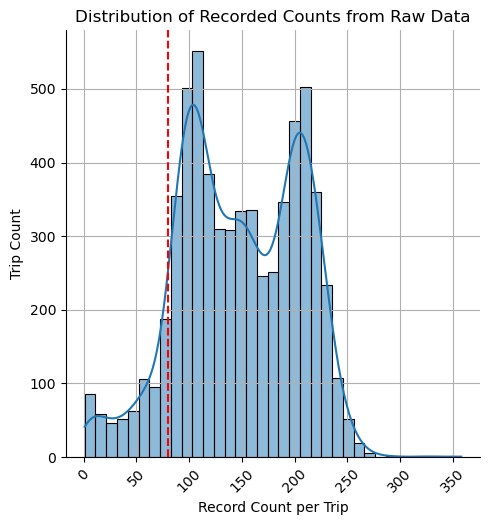

(6356, 10)
(5987, 16)
(246, 10)
(1368, 16)
(4127, 16)


In [46]:
filtered_aggregated_data = aggregated_data[aggregated_data['RecordCount'] >= np.quantile(aggregated_data['RecordCount'], 0.1)]
# filtered_aggregated_data = aggregated_data
sns.displot( data=aggregated_data["RecordCount"], kde=True )

# Customize the plot
plt.title('Distribution of Recorded Counts from Raw Data')
plt.xlabel('Record Count per Trip')
plt.ylabel('Trip Count')
plt.xticks(rotation=45)
plt.axvline(x=np.quantile(aggregated_data['RecordCount'], 0.1), color='red', linestyle='dashed', label='Percentile 10%')
# plt.legend(title='Bus Line')
plt.grid(True)

plt.show()
# print(filtered_aggregated_data.shape)
filtered_aggregated_data = filtered_aggregated_data.merge(service_lookup_table[service_lookup_id_cols+['RouteRef', 'JourneyPatternSectionRefs']], 'left', left_on=siri_id_cols, right_on=service_lookup_id_cols)
dup_check = filtered_aggregated_data.groupby(unique_idetifier_cols+['TripId'], as_index=False).agg(
    count = ('TripId','count')
)
dup_check = dup_check[dup_check['count']>1].reset_index()
missing_data = filtered_aggregated_data[filtered_aggregated_data['RouteRef'].isna()]
collected_trip_data = filtered_aggregated_data[~filtered_aggregated_data['TripId'].isin(dup_check['TripId'])].copy()
collected_trip_data = collected_trip_data[~collected_trip_data['TripId'].isin(missing_data['TripId'])].copy()
removed_sub100_contents = aggregated_data[~aggregated_data['TripId'].isin(filtered_aggregated_data['TripId'])]
removed_dup_contents = dup_check

print(aggregated_data.shape)
print(filtered_aggregated_data.shape)
print(dup_check.shape)
print(missing_data.shape)
print(collected_trip_data.shape)

In [59]:
missing_data['TripId'].unique().shape

(1368,)

In [29]:
missing_data.groupby('LineRef').agg(
    missing_trip_count = ('TripId', 'count')
).to_clipboard()

In [67]:
overview_raw_data = filtered_aggregated_data.copy()
overview_raw_data = overview_raw_data[~overview_raw_data['TripId'].isin(dup_check['TripId'])].copy()
overview_raw_data['DirectionCheck'] = overview_raw_data.apply(lambda x: x['DirectionRef']+'_missing' if (x['TripId'] in missing_data['TripId'].unique().tolist()) else x['DirectionRef'], axis=1)
overview_raw_data

,LineRef,DirectionRef,VehicleRef,BlockRef,DatedVehicleJourneyRef,OriginAimedDepartureTime,DestinationAimedArrivalTime,RecordCount,TripId,FileName,LineName,Direction,JourneyCode,BlockNumber,RouteRef,JourneyPatternSectionRefs,DirectionCheck
0,70,inbound,FBRI-35106,7004,1510,2024-07-15 14:10:00+00:00,2024-07-15 15:41:00+00:00,249,9c8b1065-af75-a66b-2b3e-7e571cf65daf,./data/raw/recorded/20240715_699.csv,70,inbound,1510,7004,RT5,JPS346,inbound
1,70,inbound,FBRI-35107,7002,1140,2024-07-15 10:40:00+00:00,2024-07-15 11:58:00+00:00,169,34cbd1c4-235b-b367-dd42-bd28136dfb19,./data/raw/recorded/20240715_699.csv,70,inbound,1140,7002,RT5,JPS337,inbound
2,70,inbound,FBRI-35107,7002,1435,2024-07-15 13:35:00+00:00,2024-07-15 15:04:00+00:00,227,6c29ffab-b40a-c8f1-43ac-8370ecc248a2,./data/raw/recorded/20240715_699.csv,70,inbound,1435,7002,RT5,JPS344,inbound
3,70,inbound,FBRI-35107,7002,1755,2024-07-15 16:55:00+00:00,2024-07-15 18:16:00+00:00,231,3230a5f7-f2c1-ed13-abdb-94ce044ad6ff,./data/raw/recorded/20240715_699.csv,70,inbound,1755,7002,RT5,JPS354,inbound
4,70,inbound,FBRI-35109,7003,1200,2024-07-15 11:00:00+00:00,2024-07-15 12:18:00+00:00,218,f9fc6e40-6d6e-72d1-02bd-49ea79f1c881,./data/raw/recorded/20240715_699.csv,70,inbound,1200,7003,RT5,JPS338,inbound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5982,m4,outbound,FBRI-39492,1403,1345,2024-07-31 12:45:00+00:00,2024-07-31 13:24:00+00:00,105,77bdd4b2-8f0b-a251-5d17-2e400c59f8a3,./data/raw/recorded/20240731_699.csv,m4,outbound,1345,1403,RT10,JPS624,outbound
5983,m4,outbound,FBRI-39492,1403,1525,2024-07-31 14:25:00+00:00,2024-07-31 15:05:00+00:00,98,38633a28-bb06-bfff-ff68-d4c1d9ed43d3,./data/raw/recorded/20240731_699.csv,m4,outbound,1525,1403,RT10,JPS628,outbound
5984,m4,outbound,FBRI-39492,1403,1720,2024-07-31 16:20:00+00:00,2024-07-31 17:04:00+00:00,125,92693bde-3c5d-e128-5781-d2f4b6147611,./data/raw/recorded/20240731_699.csv,m4,outbound,1720,1403,RT10,JPS634,outbound
5985,m4,outbound,FBRI-39492,1403,1915,2024-07-31 18:15:00+00:00,2024-07-31 18:52:00+00:00,98,57e39d35-f232-5b20-3353-a2633795dd80,./data/raw/recorded/20240731_699.csv,m4,outbound,1915,1403,RT10,JPS639,outbound


<Figure size 800x600 with 0 Axes>

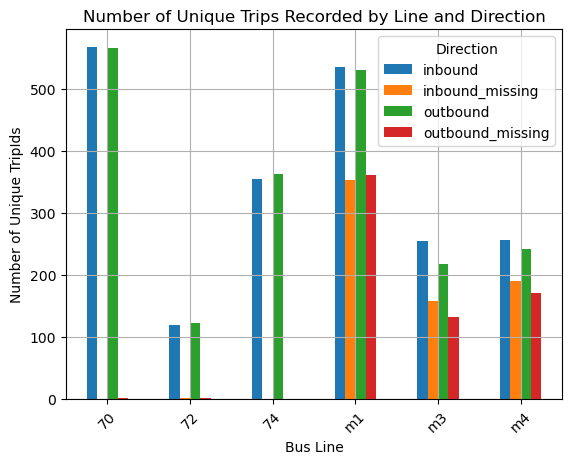

In [68]:
trip_counts = overview_raw_data.groupby(['LineRef', 'DirectionCheck'])['TripId'].nunique().reset_index()

# Pivoting the data to create a format suitable for a grouped bar chart
trip_counts_pivot = trip_counts.pivot(index='LineRef', columns='DirectionCheck', values='TripId').fillna(0)

# Plotting the grouped bar chart
plt.figure(figsize=(8,6))
trip_counts_pivot.plot(kind='bar', stacked=False)

plt.title('Number of Unique Trips Recorded by Line and Direction')
plt.xlabel('Bus Line')
plt.ylabel('Number of Unique TripIds')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Direction')

plt.show()

# Processed Data EDA

1. Line distribution: Inside the data, how many lines are active? The sample per lines?
2. GPS error boxplot --> range of acceptable signal

Which line sticks best to their plan?
    Is this line reliable to go from A to B: Consistent routing
1. Matched percentage histogram by line
2. Diversion count
    Is this line reliable to go from A to B on time: Consistent timing
1. Histgram/Boxplot of mean deviation time by line
2. Table of ontime, late and early line segments by line
3. Percentage of ontime to key place by line

### Data Overview

<Figure size 800x600 with 0 Axes>

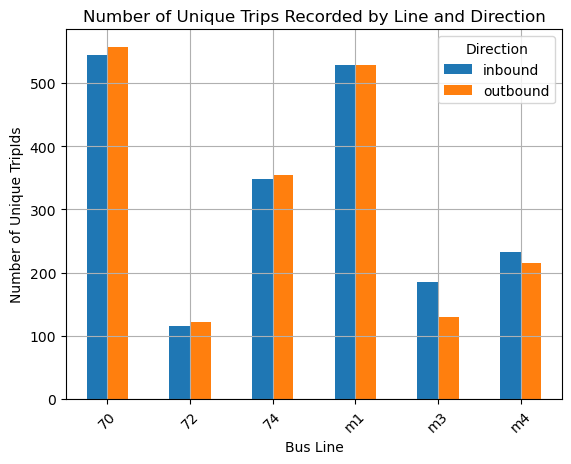

In [69]:
trip_counts = trip_stats.groupby(['Line', 'Direction'])['TripId'].nunique().reset_index()

# Pivoting the data to create a format suitable for a grouped bar chart
trip_counts_pivot = trip_counts.pivot(index='Line', columns='Direction', values='TripId').fillna(0)

# Plotting the grouped bar chart
plt.figure(figsize=(8,6))
trip_counts_pivot.plot(kind='bar', stacked=False)

plt.title('Number of Unique Trips Recorded by Line and Direction')
plt.xlabel('Bus Line')
plt.ylabel('Number of Unique TripIds')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Direction')

plt.show()

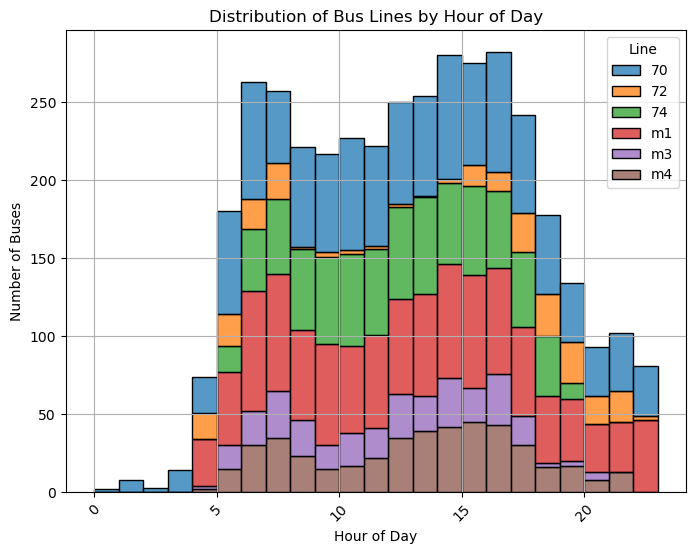

In [70]:
# Plot the distribution of bus lines by hour of day
plt.figure(figsize=(8,6))
sns.histplot(data=trip_stats, x='Hour', hue='Line', multiple='stack', binwidth=1)

# Customize the plot
plt.title('Distribution of Bus Lines by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Buses')
plt.xticks(rotation=45)
# plt.legend(title='Bus Line')
plt.grid(True)

# Show the plot
plt.show()

## Overall Line Performance

In [2]:
# Aggregate metrics for each bus line
line_summary = trip_stats.groupby(['Line','Direction']).agg(
    MeanDeviation = ('MeanDeviation', 'mean'),                              # Average time deviation
    MedianGpsError = ('MedianGpsError', 'median'),                          # Median GPS error
    DiversionPercentage=('IsDiverted', calculate_percentage),               # Percentage of trips with diversions
    DivertedMoreThan3Stops = ('DiversionData', calculate_diversion_percentage), # Percentage of trips with diversions longr than 1500m (3 stops)
    OntimePercentage=('OntimePercentage', 'mean'),                          # Average on-time percentage
    LatePercentage=('LatePercentage', 'mean'),                              # Average late percentage
    EarlyPercentage=('EarlyPercentage', 'mean'),                            # Average early percentage
    MatchedPercentage=('MatchedPercentage', 'mean'),                        # Average matched percentage
    DeviationPerKm=('DeviationPerKm', 'mean'),                              # Average deviation per kilometer
    BristolTempleMeadsTimeDiff=('BristolTempleMeadsTimeDiff', 'mean'),      # Average time difference at Bristol Temple Meads
    BristolParkwayTimeDiff=('BristolParkwayTimeDiff', 'mean'),              # Average time difference at Bristol Parkway
    BristolCityCenterTimeDiff=('BristolCityCenterTimeDiff', 'mean')         # Average time difference at Bristol City Center
    ).reset_index()

# Display the summary
line_summary.to_clipboard()

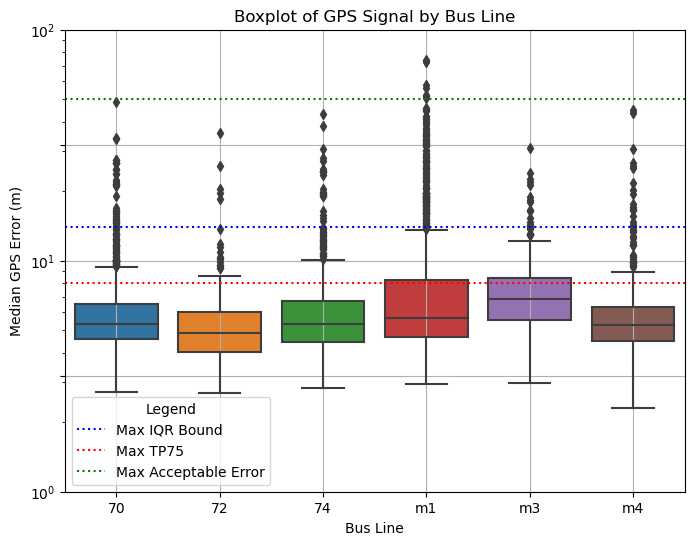

In [11]:
gps_error = trip_stats[trip_stats['TripType']!='Other']
plt.figure(figsize=(8, 6))

# Create a boxplot of GPS signal by line
sns.boxplot(data=gps_error, x='Line', y='MedianGpsError')
plt.axhline(y = 14, color = 'blue', linestyle = 'dotted', label='Max IQR Bound')

plt.axhline(y = 8, color = 'red', linestyle = 'dotted', label='Max TP75')
plt.axhline(y = 50, color = 'green', linestyle = 'dotted', label='Max Acceptable Error')

# Customize the plot
plt.title('Boxplot of GPS Signal by Bus Line')
plt.xlabel('Bus Line')
plt.ylabel('Median GPS Error (m)')
plt.yscale('log')
plt.yticks(np.logspace(start=0, stop=2, num=5))
plt.legend(title='Legend')
plt.grid(True)

# Show the plot
plt.show()

## Consistent Routing

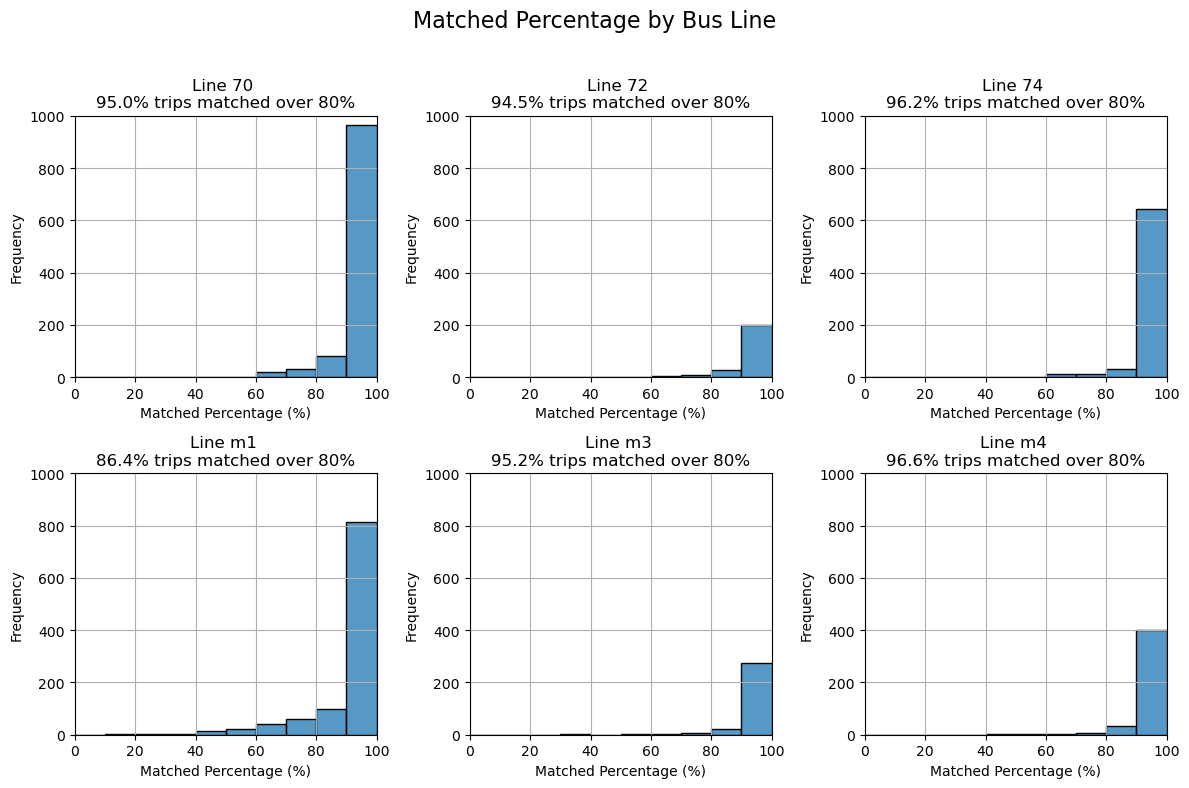

In [2]:
matched_graph = trip_stats.copy()
matched_graph['MatchedPercentage'] = matched_graph['MatchedPercentage'] * 100

# Set up the figure size and 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot individual histograms for each line
lines = matched_graph['Line'].unique()

for i, line in enumerate(lines):
    total_trips = matched_graph[matched_graph['Line'] == line].shape[0]
    high_matched_trips = matched_graph[(matched_graph['Line'] == line) & (matched_graph['MatchedPercentage'] > 80)].shape[0]
    high_matched_percentage = (high_matched_trips / total_trips) * 100
    sns.histplot(data=matched_graph[matched_graph['Line'] == line], x='MatchedPercentage', bins=range(0, 101, 10), ax=axes[i])
    axes[i].set_title(f'Line {line} \n{high_matched_percentage:.1f}% trips matched over 80%')
    axes[i].set_xlabel('Matched Percentage (%)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)
    axes[i].set_xlim(0,100)
    axes[i].set_ylim(0,1000)

# Common title for the entire figure
plt.suptitle('Matched Percentage by Bus Line', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.xticks(rotation=45)
# plt.legend(title='Bus Line')

# Show the plot
plt.show()

m1 analysis

In [6]:
def extract_diversion_data(series, field):
    result = []
    for s in series:
        e_result =[]
        if s!=s:
            continue
        for i in s:
            e_result.append(i[field])
        result.append(e_result)
    return result

In [94]:
vehicle_id = aggregated_data[['TripId', 'VehicleRef']]

m1_data = trip_stats[trip_stats['Line']=='m1']
m1_data = m1_data[m1_data['DiversionSegmentCount']>0]
m1_data['DiversionLength'] = extract_diversion_data(m1_data['DiversionData'], 'diverted_path_length')
m1_data['DiversionTotalLength'] = m1_data['DiversionLength'].apply(lambda x: sum(x))
m1_data['AverageDiversionLength'] = m1_data['DiversionTotalLength']/m1_data['DiversionSegmentCount']
m1_data = m1_data.merge(vehicle_id,'left',on='TripId')

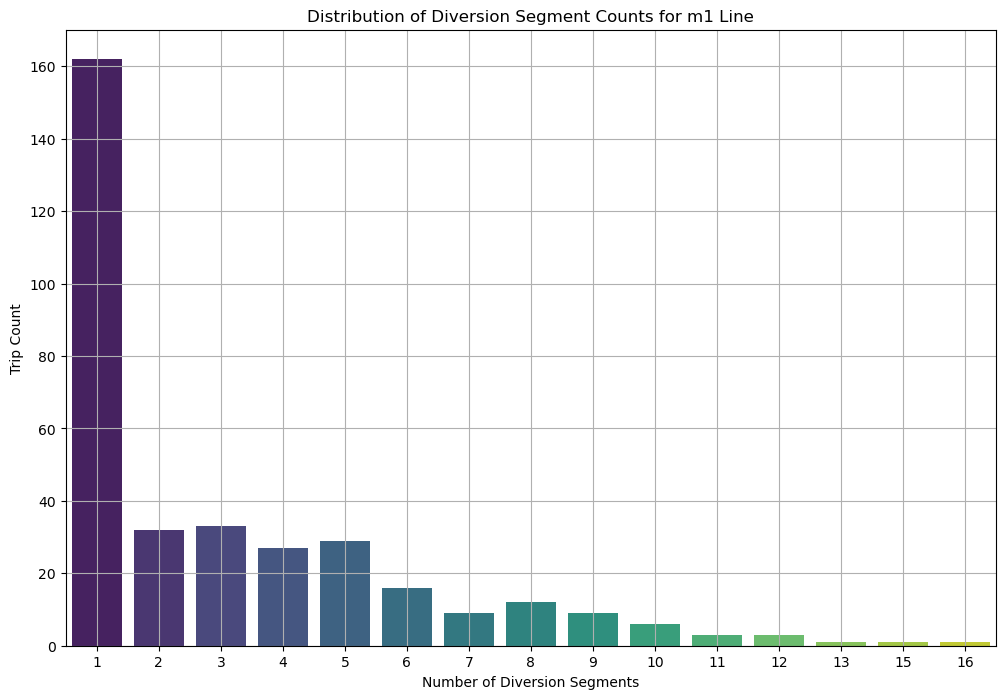

In [26]:
plt.figure(figsize=(12, 8))
sns.countplot(data=m1_data, x='DiversionSegmentCount', palette='viridis')
plt.title('Distribution of Diversion Segment Counts for m1 Line')
plt.xlabel('Number of Diversion Segments')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()

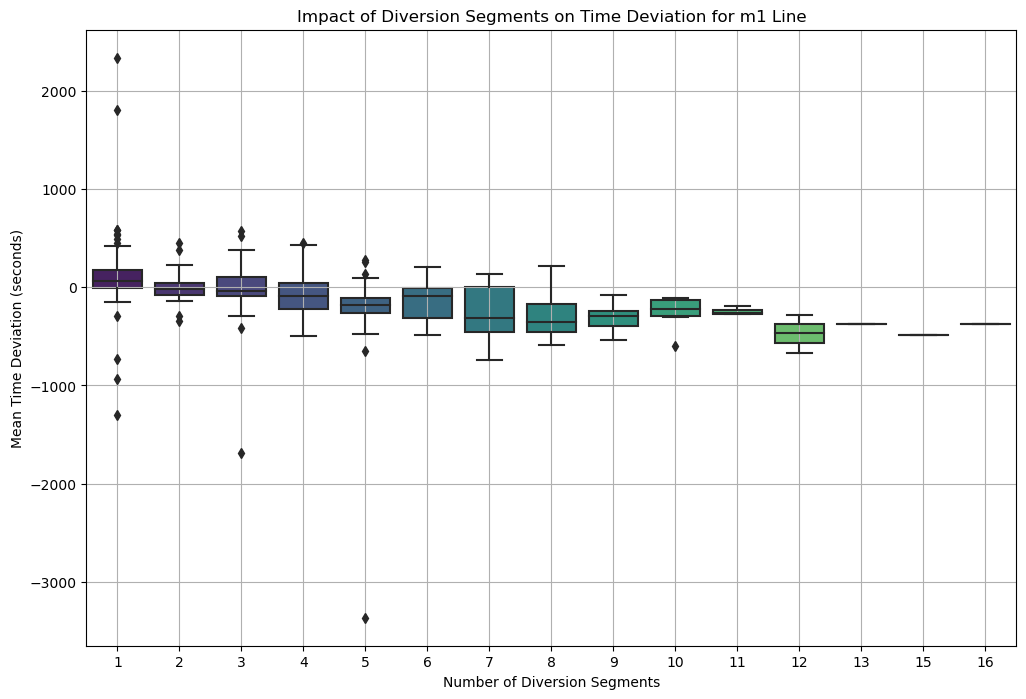

In [5]:
# Plotting the box plot of time deviation by the number of diversion segments
plt.figure(figsize=(12, 8))
sns.boxplot(data=m1_data, x='DiversionSegmentCount', y='MeanDeviation', palette='viridis')
plt.title('Impact of Diversion Segments on Time Deviation for m1 Line')
plt.xlabel('Number of Diversion Segments')
plt.ylabel('Mean Time Deviation (seconds)')
plt.grid(True)
plt.show()

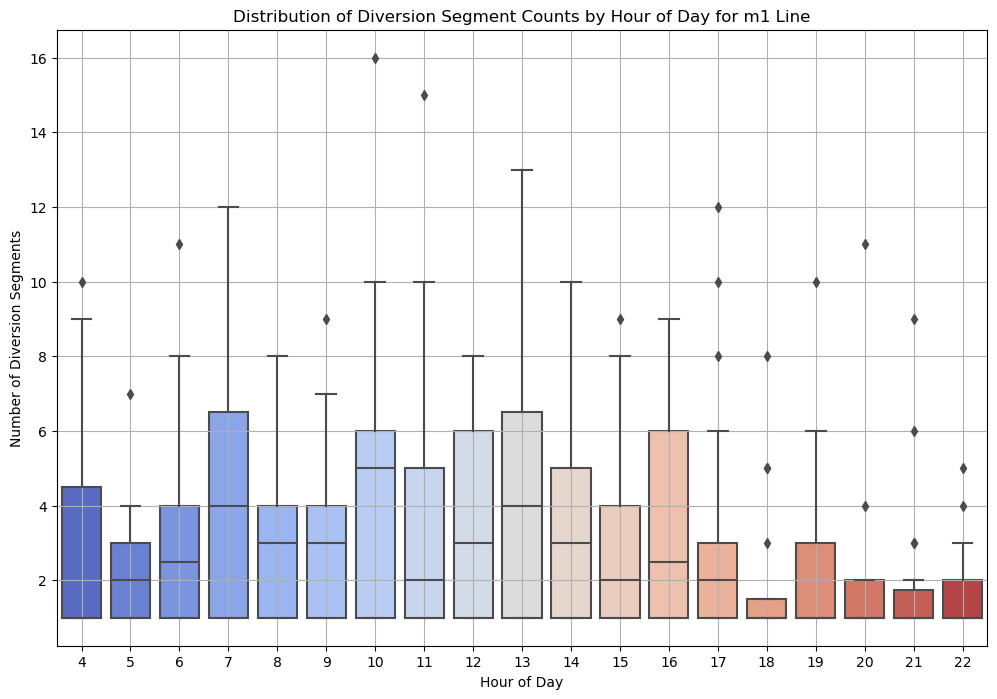

In [27]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=m1_data, x='Hour', y='DiversionSegmentCount', palette='coolwarm')
plt.title('Distribution of Diversion Segment Counts by Hour of Day for m1 Line')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Diversion Segments')
plt.grid(True)
plt.show()

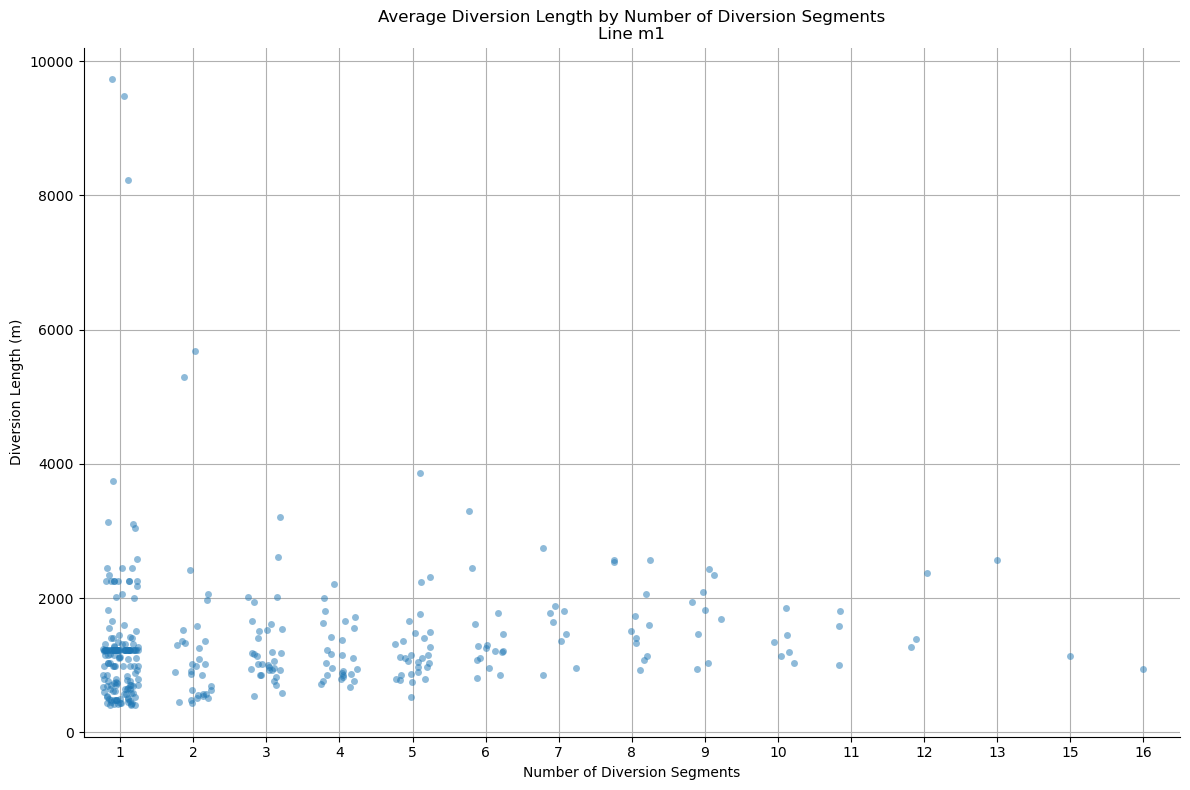

In [66]:
plt.figure(figsize=(12, 8))

# Swarm for Diversion Length by Diversion Segment Count
# plt.subplot(3, 1, 1)
sns.stripplot(data=m1_data, x='DiversionSegmentCount', y='AverageDiversionLength', alpha = 0.5, jitter=0.25)
plt.title('Average Diversion Length by Number of Diversion Segments\nLine m1')
plt.xlabel('Number of Diversion Segments')
plt.ylabel('Diversion Length (m)')
plt.grid(True)
sns.despine()

# Adjust layout for better spacing
# plt.xlim(-1,5.5)
# plt.ylim(0,4000)
plt.tight_layout()

# Show the plots
plt.show()

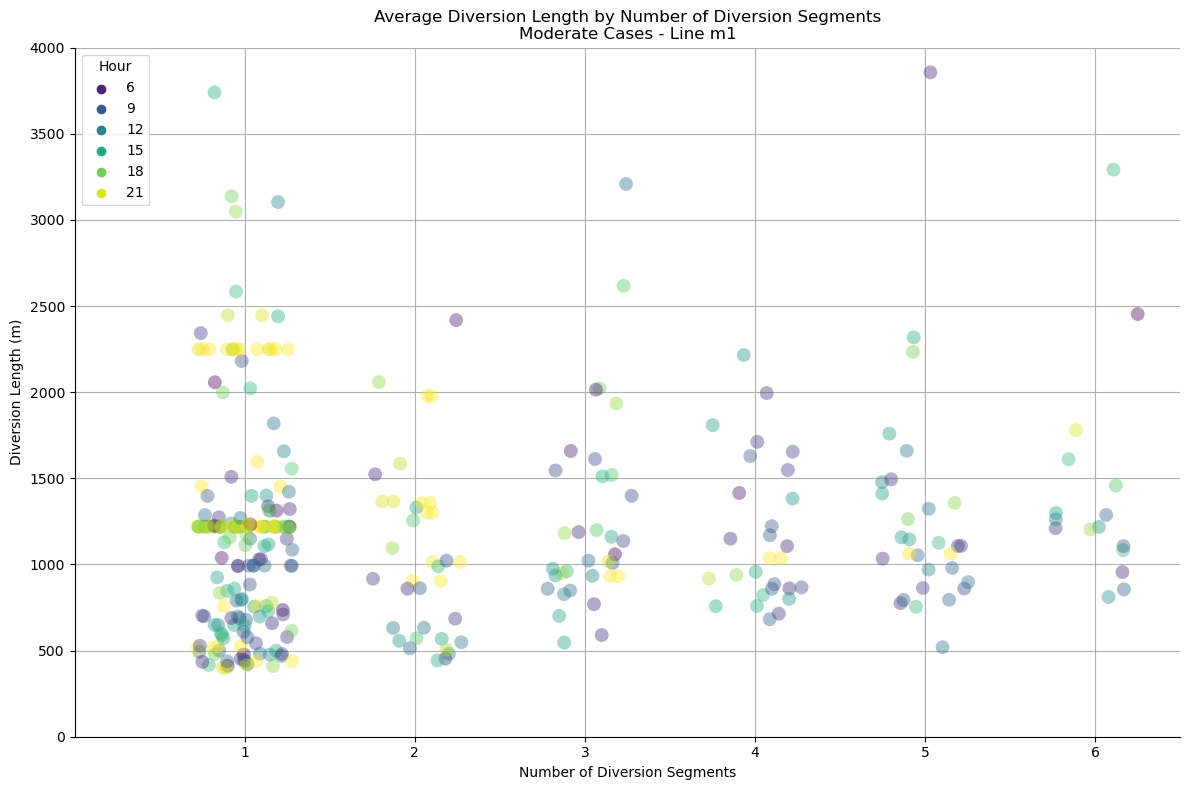

In [96]:
plt.figure(figsize=(12, 8))

# Swarm for Diversion Length by Diversion Segment Count
# plt.subplot(3, 1, 1)
sns.stripplot(data=m1_data[m1_data['AverageDiversionLength']>0], x='DiversionSegmentCount', y='AverageDiversionLength', alpha = 0.4, jitter=0.28, hue='Hour', palette='viridis', size = 10)
plt.title('Average Diversion Length by Number of Diversion Segments\nModerate Cases - Line m1')
plt.xlabel('Number of Diversion Segments')
plt.ylabel('Diversion Length (m)')
plt.grid(True)
sns.despine()

# Adjust layout for better spacing
plt.xlim(-1,5.5)
plt.ylim(0,4000)
plt.tight_layout()

# Show the plots
plt.show()

Moderate group

In [ ]:
m1_data_moderate = m1_data[(m1_data['DiversionSegmentCount'] >=2) & (m1_data['DiversionSegmentCount'] <=6)].copy()
# m1_data_moderate = m1_data[(m1_data['DiversionSegmentCount'] >=2)].copy()
# m1_data_moderate = m1_data[(m1_data['DiversionSegmentCount'] >=6)].copy()
m1_data_moderate['MatchedPercentage'] = m1_data_moderate['MatchedPercentage']*100

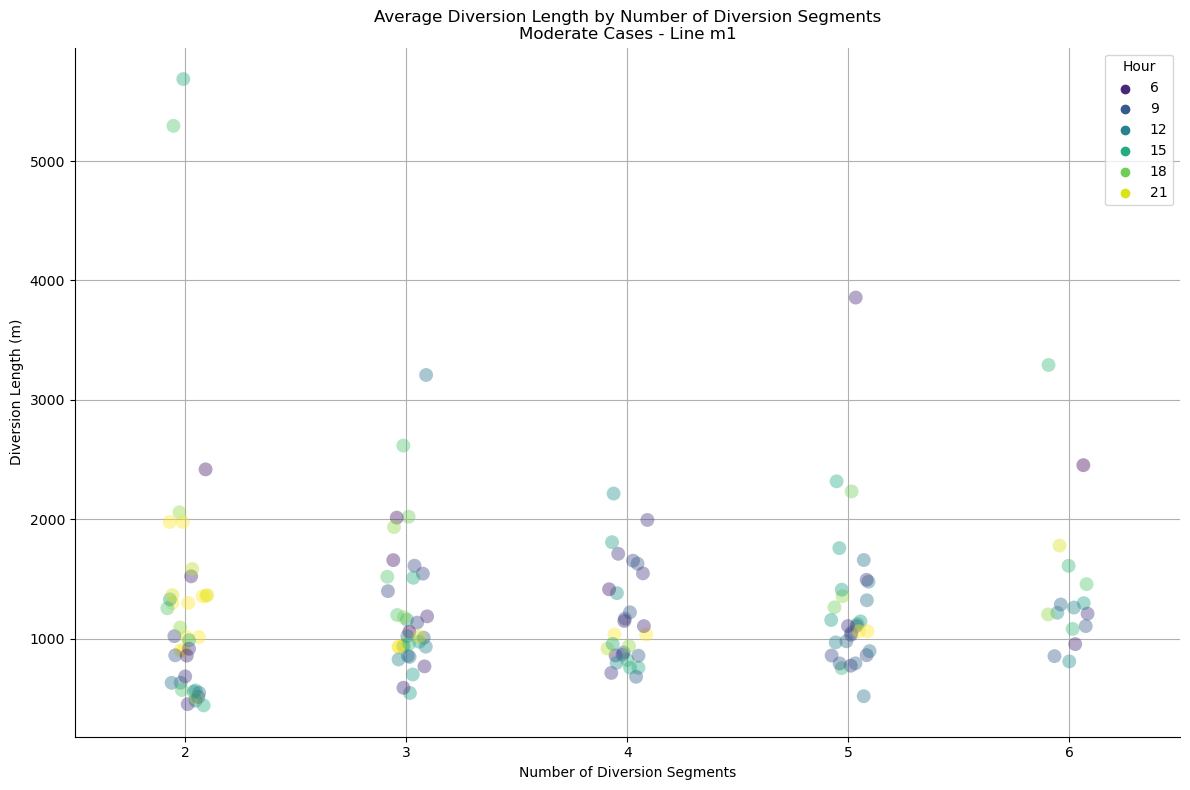

In [149]:
plt.figure(figsize=(12, 8))

# Swarm for Diversion Length by Diversion Segment Count
# plt.subplot(3, 1, 1)
sns.stripplot(data=m1_data_moderate, x='DiversionSegmentCount', y='AverageDiversionLength', alpha = 0.4, jitter=0.1, hue='Hour', palette='viridis', size = 10)
plt.title('Average Diversion Length by Number of Diversion Segments\nModerate Cases - Line m1')
plt.xlabel('Number of Diversion Segments')
plt.ylabel('Diversion Length (m)')
plt.grid(True)
sns.despine()

# Adjust layout for better spacing
# plt.xlim(-1,5.5)
# plt.ylim(0,4000)
plt.tight_layout()

# Show the plots
plt.show()

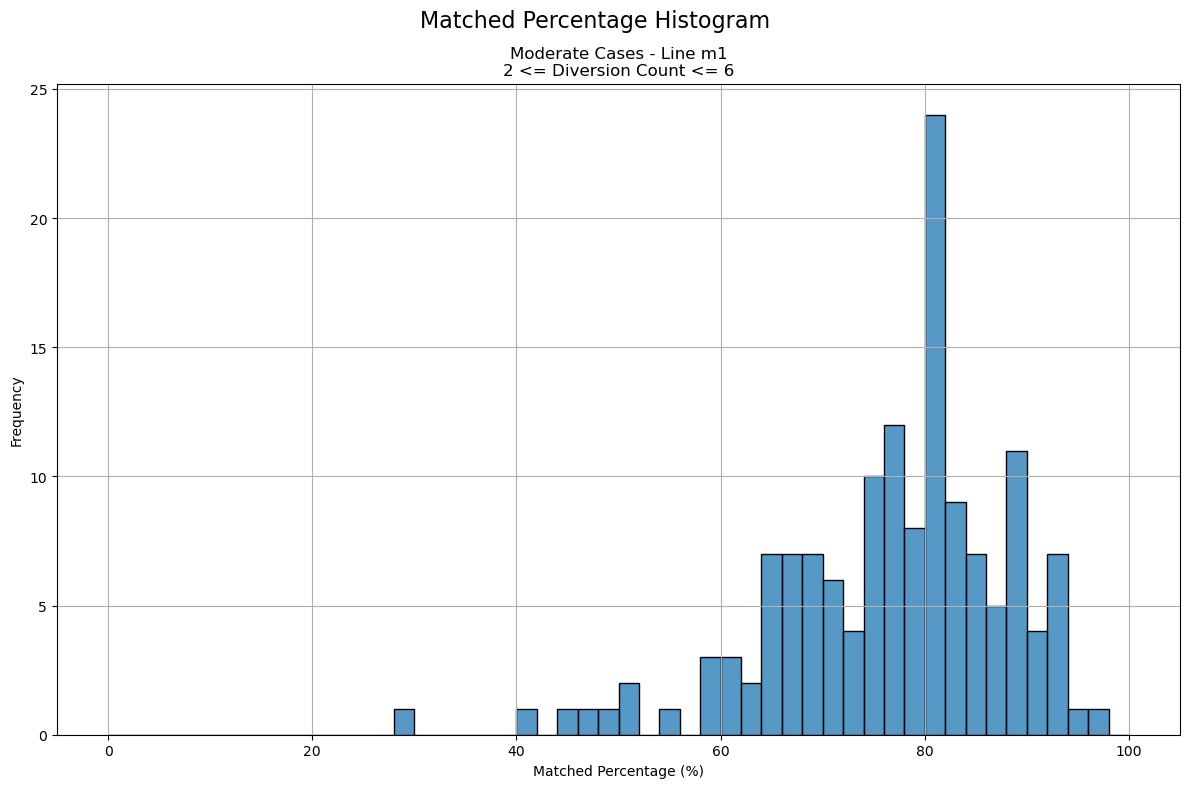

In [141]:
# total_trips = matched_graph[matched_graph['Line'] == line].shape[0]
# high_matched_trips = matched_graph[(matched_graph['Line'] == line) & (matched_graph['MatchedPercentage'] > 80)].shape[0]
# high_matched_percentage = (high_matched_trips / total_trips) * 100
plt.figure(figsize=(12, 8))
plt.grid(True)
sns.histplot(data=m1_data_moderate, x='MatchedPercentage', bins=range(0, 101, 2))
# sns.kdeplot(data=m1_data_moderate, x='MatchedPercentage', hue='VehicleRef', fill=True)
plt.xlabel('Matched Percentage (%)')
plt.ylabel('Frequency')
plt.suptitle('Matched Percentage Histogram', fontsize=16)
plt.title('Moderate Cases - Line m1\n2 <= Diversion Count <= 6')

plt.tight_layout()

# Show the plots
plt.show()

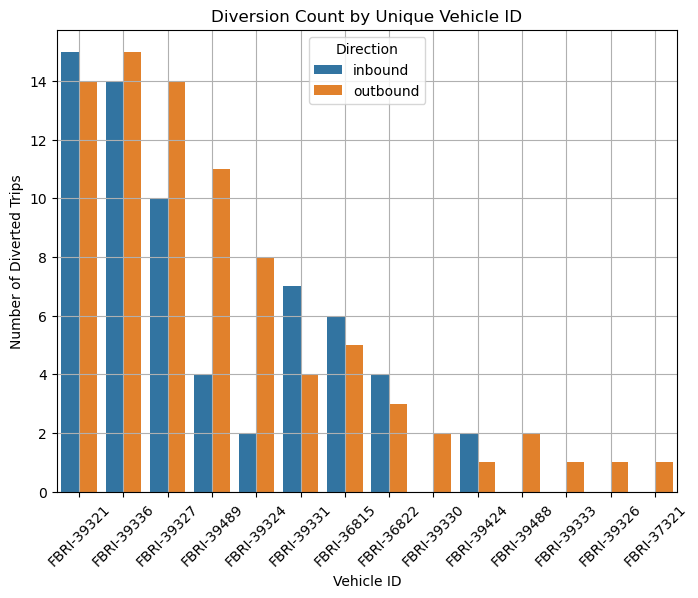

In [142]:
vehicle_stability_check = m1_data_moderate.groupby(['VehicleRef','Direction'], as_index=False).agg(
    DivertedTripCount = ('TripId', 'count')
)
vehicle_stability_check.sort_values('DivertedTripCount', ascending=False, inplace=True)

# Plotting the grouped bar chart
plt.figure(figsize=(8,6))
sns.barplot(data=vehicle_stability_check, x="VehicleRef", y="DivertedTripCount", hue='Direction')

plt.title('Diversion Count by Unique Vehicle ID')
plt.xlabel('Vehicle ID')
plt.ylabel('Number of Diverted Trips')
plt.xticks(rotation=45)
plt.grid(True)
# plt.legend(title='Direction')

plt.show()

Extreme group

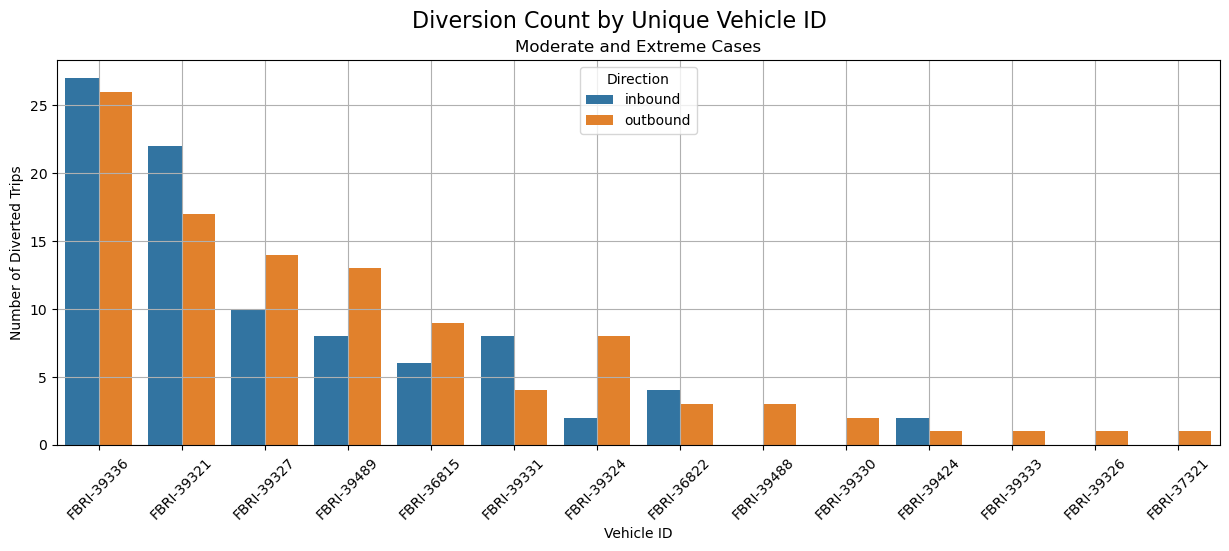

In [157]:
m1_data_e = m1_data[(m1_data['DiversionSegmentCount'] >=2)].copy()
m1_data_e['MatchedPercentage'] = m1_data_e['MatchedPercentage']*100

vehicle_stability_check = m1_data_e.groupby(['VehicleRef','Direction'], as_index=False).agg(
    DivertedTripCount = ('TripId', 'count')
)
vehicle_stability_check.sort_values('DivertedTripCount', ascending=False, inplace=True)

# Plotting the grouped bar chart
plt.figure(figsize=(15,5))
sns.barplot(data=vehicle_stability_check, x="VehicleRef", y="DivertedTripCount", hue='Direction')

plt.suptitle('Diversion Count by Unique Vehicle ID', fontsize=16)
plt.title('Moderate and Extreme Cases')
plt.xlabel('Vehicle ID')
plt.ylabel('Number of Diverted Trips')
plt.xticks(rotation=45)
plt.grid(True)
# plt.legend(title='Direction')

plt.show()

## Time Analysis

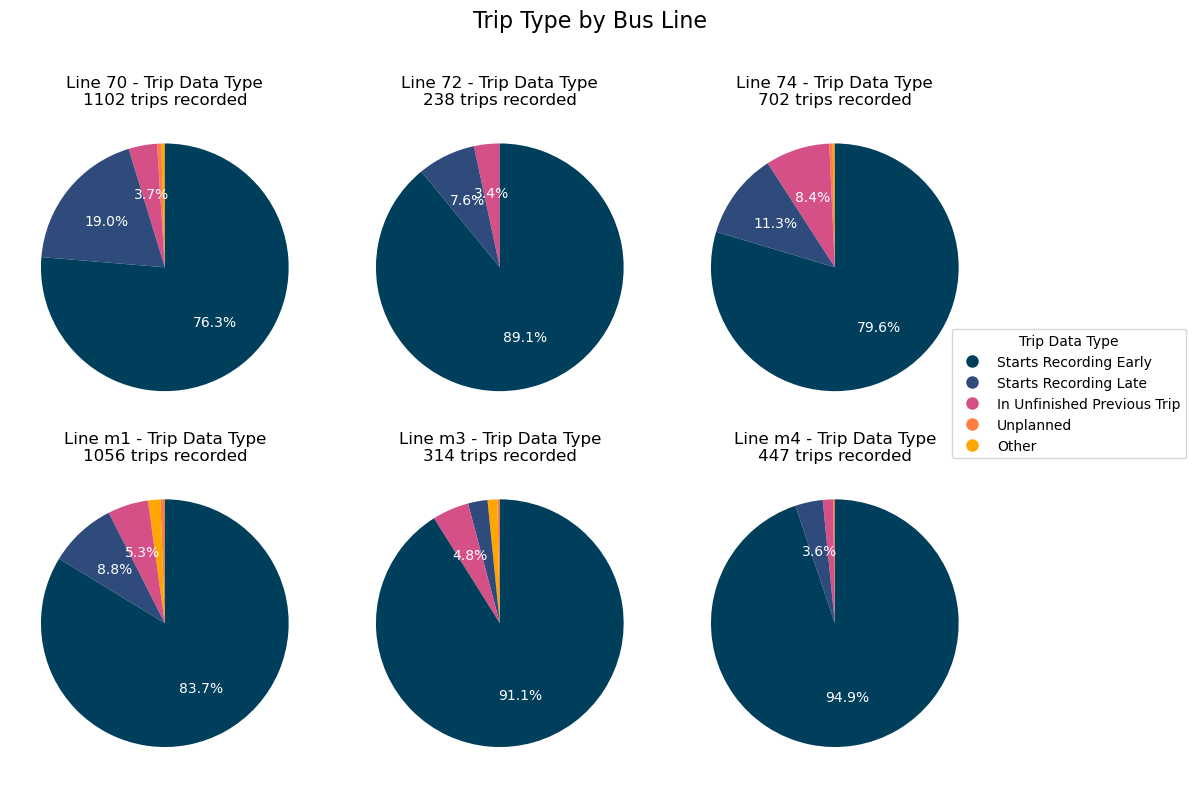

In [3]:
def autopct_threshold(pct):
    return f'{pct:.1f}%' if pct >= 3 else ''

trip_type_count = (trip_stats.groupby(['Line','TripType'], as_index=False)
                   .agg(
                       TripCount = ('TripId','count')
                   ))
trip_type_count['Percentage'] = trip_type_count.groupby(['Line'], as_index=False)['TripCount'].apply(lambda x: 100*x/x.sum())
# trip_type_count
trip_type_count.sort_values(['TripCount'], inplace=True)


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

colors = {
    'Starts Recording Early': '#003f5c',
    'Starts Recording Late': '#2f4b7c',
    'In Unfinished Previous Trip': '#d45087',
    'Unplanned': '#ff7c43',
    'Other': '#ffa600'
}

# List of unique lines
lines = sorted(trip_type_count['Line'].unique())

# Loop through each line to create a pie chart
for i, line in enumerate(lines):
    # Filter data for the current line
    line_data = trip_type_count[trip_type_count['Line'] == line]
    line_colors = [colors[trend] for trend in line_data['TripType']]
    
    # Get the subplot axis
    ax = axes[i//3, i%3]
    
    # Plot the pie chart
    wedges, _ , autotexts = ax.pie(line_data['TripCount'], autopct=autopct_threshold, startangle=90, colors=line_colors)
    
    # Set the title for each subplot
    ax.set_title(f'Line {line} - Trip Data Type\n{sum(line_data["TripCount"])} trips recorded')
    for autotext in autotexts:
        autotext.set_color('white')

legend_labels = list(colors.keys())
legend_colors = list(colors.values())
fig.legend(wedges, legend_labels, loc='center right', title="Trip Data Type", handles=[plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=color) for key, color in colors.items()])


# Adjust layout
plt.suptitle('Trip Type by Bus Line', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.96])

# Show the plot
plt.show()

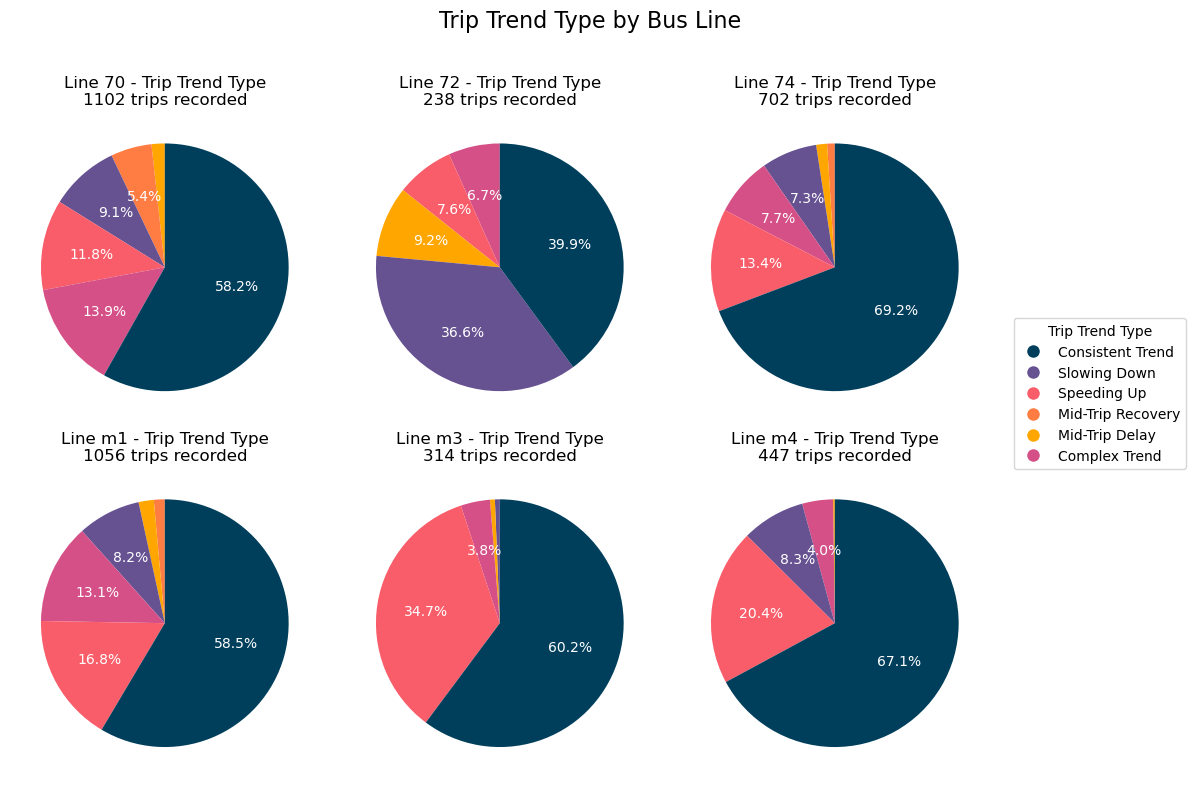

In [6]:
trip_type_count = (trip_stats.groupby(['Line','TripTrendType'], as_index=False)
                   .agg(
                       TripCount = ('TripId','count')
                   ))
trip_type_count['Percentage'] = trip_type_count.groupby(['Line'], as_index=False)['TripCount'].apply(lambda x: 100*x/x.sum())
# trip_type_count
trip_type_count.sort_values(['TripCount'], inplace=True)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

colors = {
    'Consistent Trend': '#003f5c',
    'Slowing Down': '#665191',
    'Speeding Up': '#f95d6a',
    'Mid-Trip Recovery': '#ff7c43',
    'Mid-Trip Delay': '#ffa600',
    'Complex Trend': '#d45087'
}

# List of unique lines
lines = sorted(trip_type_count['Line'].unique())


# Loop through each line to create a pie chart
for i, line in enumerate(lines):
    # Filter data for the current line
    line_data = trip_type_count[trip_type_count['Line'] == line]
    line_colors = [colors[trend] for trend in line_data['TripTrendType']]
    
    # Get the subplot axis
    ax = axes[i//3, i%3]
    
    # Plot the pie chart
    wedges, _ , autotexts = ax.pie(line_data['TripCount'], autopct=autopct_threshold, startangle=90, colors=line_colors)
    
    # Set the title for each subplot
    ax.set_title(f'Line {line} - Trip Trend Type\n{sum(line_data["TripCount"])} trips recorded')
    for autotext in autotexts:
        autotext.set_color('white')


legend_labels = list(colors.keys())
legend_colors = list(colors.values())
fig.legend(wedges, legend_labels, loc='center right', title="Trip Trend Type", handles=[plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=color) for key, color in colors.items()])

# Adjust layout
plt.suptitle('Trip Trend Type by Bus Line', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.96])

# Show the plot
plt.show()

In [61]:
trip_type_count

,Line,TripTrendType,TripCount,Percentage
0,70,Complex Trend,233,21.143376
1,70,Consistently On-Time,641,58.166969
2,70,Mid-Trip Delay,9,0.816697
3,70,Mid-Trip Recovery,43,3.901996
4,70,Slowing Down,71,6.442831
5,70,Speeding Up,105,9.528131
6,72,Complex Trend,56,23.529412
7,72,Consistently On-Time,95,39.915966
8,72,Mid-Trip Delay,10,4.201681
9,72,Slowing Down,63,26.470588


In [ ]:
def median_ignore_zeros(series):
    return series[series != 0].median()

def potential_gps_error(series):
    return series[series > 14].count()

In [ ]:
diversion_count = (trip_stats.groupby(['Line'], as_index=False)
                   .agg(
                       TotalTripCount = ('TripId','count'),
                       DivertedTripCount = ('IsDiverted','sum'),
                       MedianDiversionSegmentCount = ('DiversionSegmentCount',median_ignore_zeros),
                       DivertedTripByPotentialGpsError = ('MedianGpsError',potential_gps_error)
                   ))
diversion_count['DiversionPercentage'] = (diversion_count['DivertedTripCount']-diversion_count['DivertedTripByPotentialGpsError'])/diversion_count['TotalTripCount']

diversion_count

,Line,TotalTripCount,DivertedTripCount,MedianDiversionSegmentCount,DivertedTripByPotentialGpsError,DiversionPercentage
0,70,1102,235,1.0,37,0.179673
1,72,238,48,1.0,5,0.180672
2,74,702,61,1.0,23,0.054131
3,m1,1056,344,2.0,144,0.189394
4,m3,314,57,1.0,18,0.124204
5,m4,447,101,1.0,18,0.185682


### Overview

In [196]:
check = trip_stats[~trip_stats['TripType'].isin(['Other','Unplanned'])]

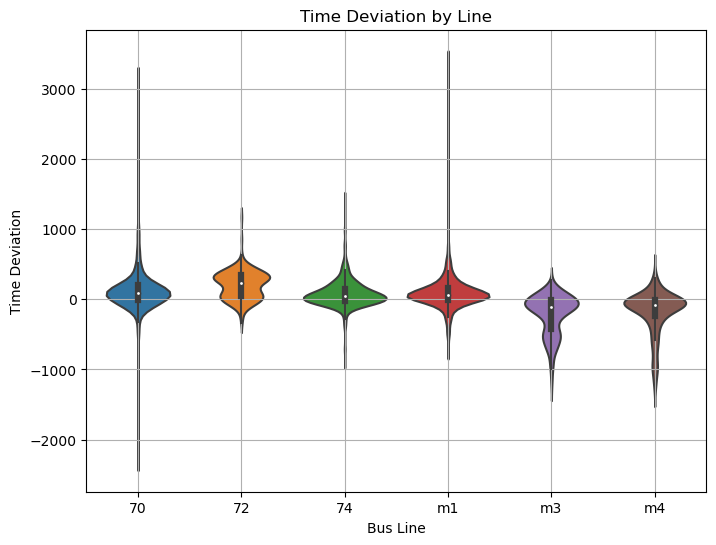

In [198]:
plt.figure(figsize=(8, 6))

# Create a violin plot of Mean Deviation by Line
sns.violinplot(data=check, x='Line', y='MeanDeviation')

# Customize the plot
plt.title('Time Deviation by Line')
plt.xlabel('Bus Line')
plt.ylabel('Time Deviation')
# plt.yscale('log')
# plt.yticks(np.logspace(start=-10, stop=2, num=5))
plt.grid(True)

# Show the plot
plt.show()

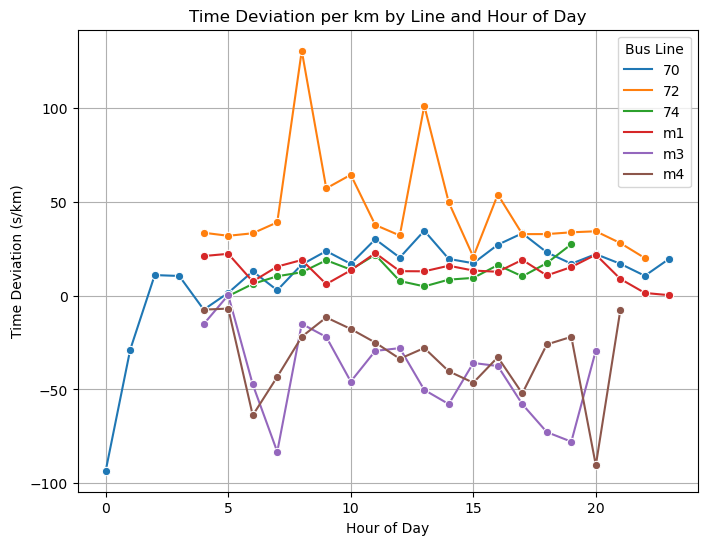

In [ ]:
# Set up the figure size
plt.figure(figsize=(8, 6))

# Create a line plot for each Line, showing DeviationPerKm by Hour
sns.lineplot(data=check, x='Hour', y='DeviationPerKm', hue='Line', marker='o', errorbar=None)

# Customize the plot
plt.title('Time Deviation per km by Line and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Time Deviation (s/km)')
plt.grid(True)
plt.legend(title='Bus Line')

# Show the plot
plt.show()

In [ ]:
ontime_stats = (trip_stats.groupby(['Line'], as_index=False)
                   .agg(
                       MeanOntimePercentage = ('OntimePercentage','mean'),
                       MeanLatePercentage = ('LatePercentage','mean'),
                       MeanEarlyPercentage = ('EarlyPercentage','mean')
                   ))

ontime_stats

,Line,MeanOntimePercentage,MeanLatePercentage,MeanEarlyPercentage
0,70,0.595045,0.178485,0.226471
1,72,0.544589,0.342703,0.112708
2,74,0.650838,0.113966,0.235196
3,m1,0.689912,0.120834,0.189254
4,m3,0.404342,0.002329,0.593328
5,m4,0.425844,0.017910,0.556246


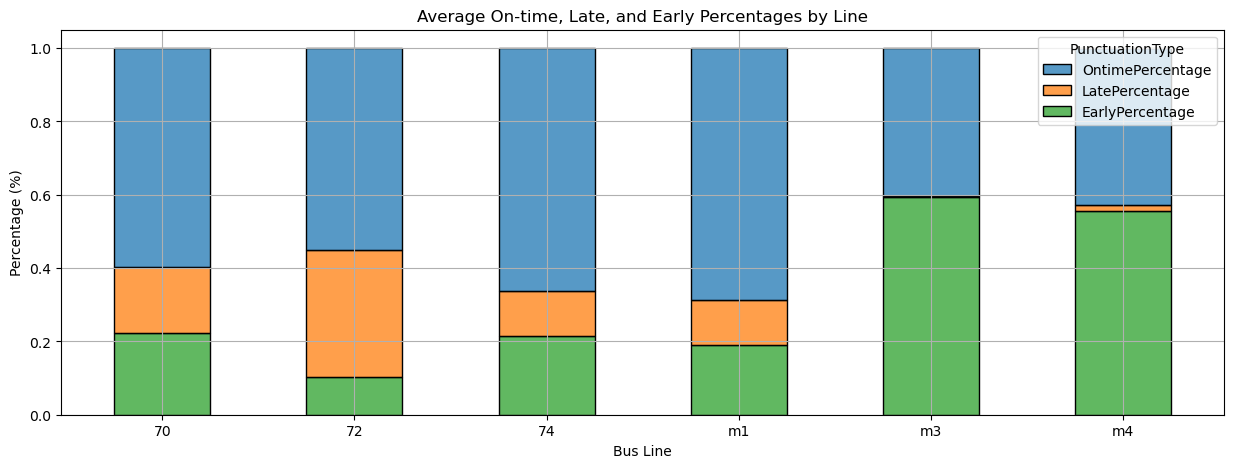

In [190]:
line_summary = trip_stats.groupby('Line').agg({
    'OntimePercentage': 'mean',
    'LatePercentage': 'mean',
    'EarlyPercentage': 'mean'
}).reset_index()

line_summary = line_summary.melt(id_vars='Line',
                                 value_name='Percentage',
                                 var_name='PunctuationType')

plt.figure(figsize=(15, 5))

# Create a stacked bar chart
# line_summary.set_index('Line').plot(kind='bar', stacked=True, figsize=(12, 8))
sns.histplot(data=line_summary, x="Line", weights='Percentage', hue='PunctuationType', multiple='stack', shrink=0.5)

# Customize the plot
plt.title('Average On-time, Late, and Early Percentages by Line')
plt.xlabel('Bus Line')
plt.ylabel('Percentage (%)')
# plt.legend(title='Punctuation Type')
plt.grid(True)

# Show the plot
plt.show()

/Users/trietdoky/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


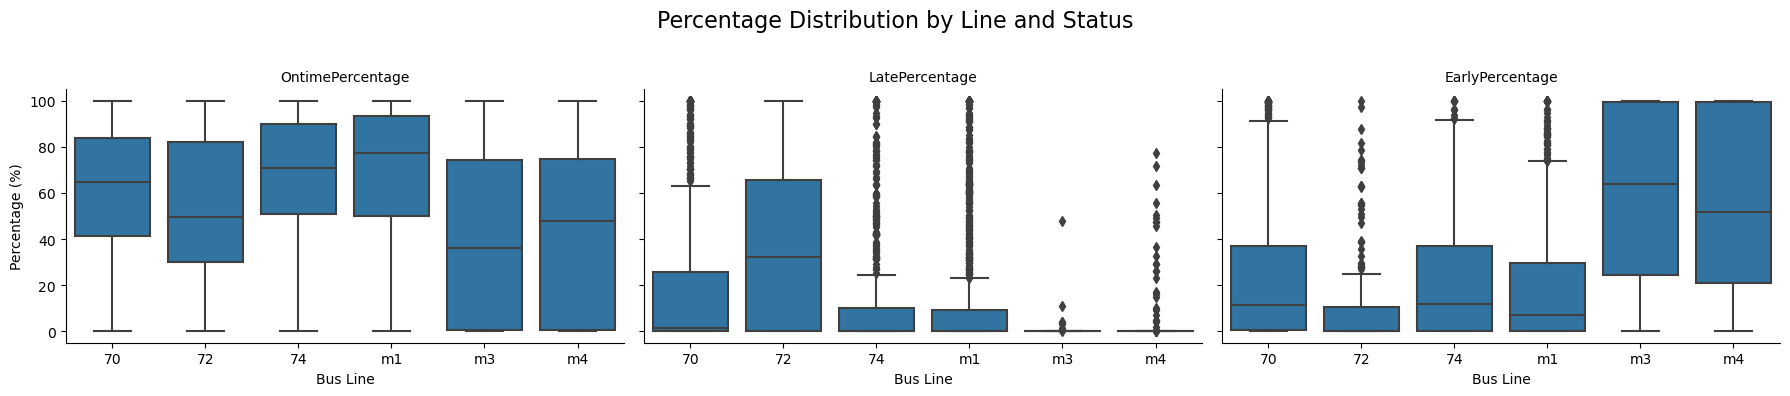

In [195]:
melted_df = trip_stats.melt(id_vars=['Line'], value_vars=['OntimePercentage', 'LatePercentage', 'EarlyPercentage'], 
                    var_name='Status', value_name='Percentage')

melted_df['Percentage'] = melted_df['Percentage']*100

# Set up the FacetGrid for each status type
g = sns.FacetGrid(melted_df, col="Status", col_wrap=3, height=4, aspect=1.5)

# Create a boxplot for each Status type
g.map(sns.boxplot, "Line", "Percentage")

# Customize the plots
g.set_axis_labels("Bus Line", "Percentage (%)")
g.set_titles("{col_name}")
g.fig.suptitle('Percentage Distribution by Line and Status', fontsize=16)
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

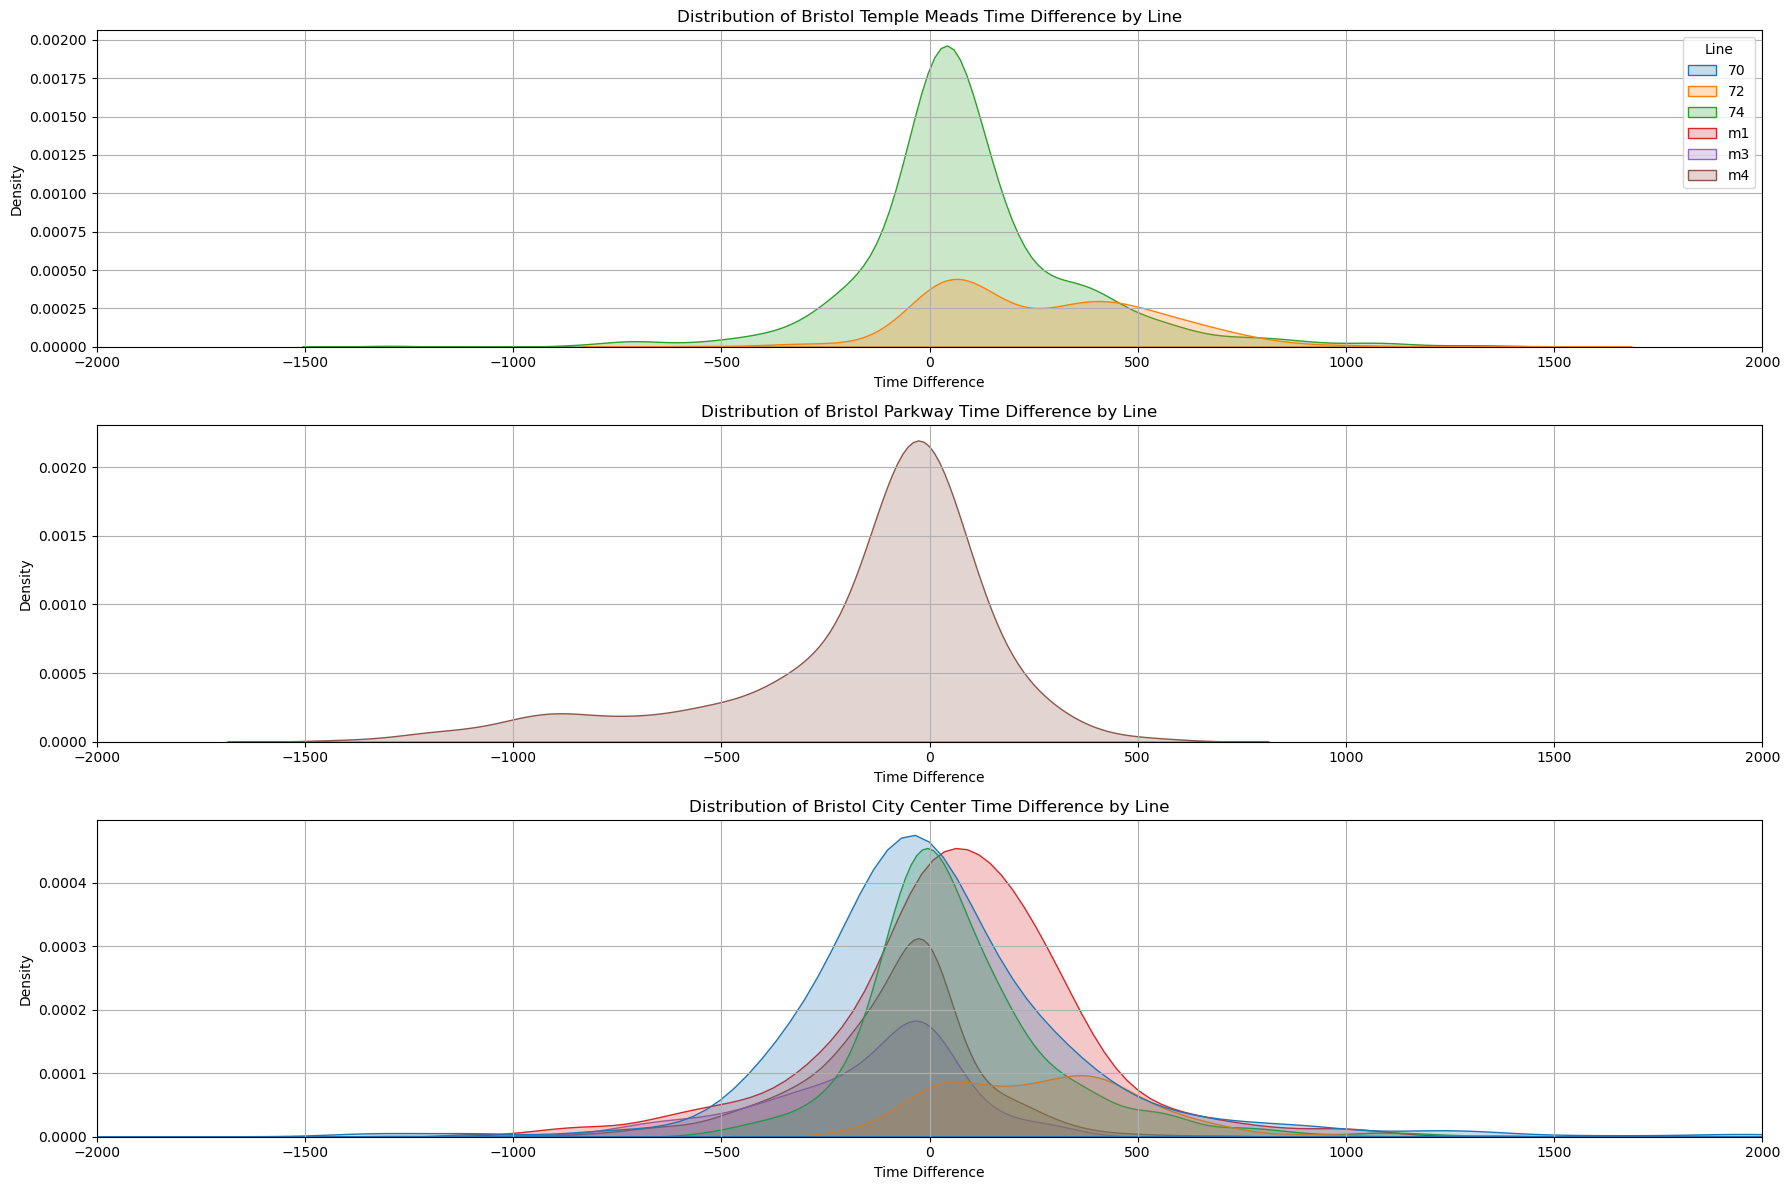

In [200]:
# Set up the figure size
plt.figure(figsize=(18, 12))

# Plot for BristolTempleMeadsTimeDiff
plt.subplot(3, 1, 1)
sns.kdeplot(data=check, x='BristolTempleMeadsTimeDiff', hue='Line', fill=True)
plt.title('Distribution of Bristol Temple Meads Time Difference by Line')
plt.xlabel('Time Difference')
plt.ylabel('Density')
plt.xlim(-2000,2000)
plt.grid(True)

# Plot for BristolParkwayTimeDiff
plt.subplot(3, 1, 2)
sns.kdeplot(data=check, x='BristolParkwayTimeDiff', hue='Line', fill=True, legend=False)
plt.title('Distribution of Bristol Parkway Time Difference by Line')
plt.xlabel('Time Difference')
plt.ylabel('Density')
plt.xlim(-2000,2000)
plt.grid(True)

# Plot for BristolCityCenterTimeDiff
plt.subplot(3, 1, 3)
sns.kdeplot(data=check, x='BristolCityCenterTimeDiff', hue='Line', fill=True, legend=False)
plt.title('Distribution of Bristol City Center Time Difference by Line')
plt.xlabel('Time Difference')
plt.xlim(-2000,2000)
plt.ylabel('Density')
plt.grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()

### 72 inbound

In [209]:
timing_72_data = trip_stats[(trip_stats['Line']=='72') & (trip_stats['Direction']=='inbound')].copy()
timing_72_data = timing_72_data[~timing_72_data['TripType'].isin(['Other','Unplanned'])]


#### Analysis

In [4]:
stats = pd.DataFrame()
planned_trip_series_72=[]
actual_trip_series_72=[]
time_diff_interp_series_72=[]
files_line_72 = [i for i in matched_trip_pkl_files if 'p_72_' in i]
direction_check = 'inbound'

for f in files_line_72:
    t_line_data = pd.read_pickle(f)

    t_trips = t_line_data['TripId'].unique().tolist()
    for trip in t_trips:
        # print(f'{trip}/',end='')
        # print(f'{trip}/')
        sample_trip = t_line_data[t_line_data['TripId']==trip].copy().reset_index(drop=True)
        sample_trip = sample_trip[sample_trip['DirectionRef']==direction_check]

        if sample_trip.shape[0] < 80:
            continue
        
        t_estimated_route = eval(sample_trip['EstimatedRoute'][0])
        # sample_trip = sample_trip[sample_trip['RecordedAtTime'] >= sample_trip['OriginAimedDepartureTime']]
        sample_trip['TimeCumSum'] = np.cumsum(sample_trip['TraveledTime'])
        sample_trip['DistanceCumSum'] = np.cumsum(sample_trip['TraveledDistanceMatched'])

        # Calculate Path Properties
        is_wrong_time = False
        is_diverted = False
        is_unplanned = False
        trip_type = 'Other'
        trip_line_name = sample_trip.iloc[0]['LineRef'] 

        t_timetable_data_service = (sample_trip[unique_idetifier_cols+['TripId']]
                            .head(1)
                            .merge(service_lookup_table[service_lookup_id_cols+['RouteRef', 'JourneyPatternSectionRefs']], 'left', 
                                left_on=siri_id_cols, right_on=service_lookup_id_cols))
        t_timetable_data_path = tracking_data.loc[
            (tracking_data['RouteId']==t_timetable_data_service['RouteRef'][0]) &
            (tracking_data['LineRef']==t_timetable_data_service['LineRef'][0])
        ]
        t_timetable_data_time = timing_data.loc[
            (timing_data['JourneyPatternSectionId']==t_timetable_data_service['JourneyPatternSectionRefs'][0]) &
            (timing_data['BlockNumber'].astype(str)==t_timetable_data_service['BlockNumber'].astype(str)[0])
        ]
        t_tracking_data = t_timetable_data_path.merge(t_timetable_data_time, 'left', 
                                                    left_on=['RouteLinkRef'], 
                                                    right_on=['RouteLinkRef']).fillna(0)

        t_tracking_data['TimeCumSum'] = np.cumsum(t_tracking_data['RunTime'])+np.cumsum(t_tracking_data['WaitTime'])
        t_tracking_data['DistanceCumSum'] = np.cumsum(t_tracking_data['Distance'])

        merged_planned_linestring = []
        for segment in t_timetable_data_path['TrackingPoints']:
            merged_planned_linestring = merged_planned_linestring + segment
        merged_planned_linestring = LineString(merged_planned_linestring)
        actual_linestring = gpd.GeoDataFrame(geometry=[t_estimated_route], crs=4326)
        planned_linestring = gpd.GeoDataFrame(geometry=[LineString(segment) for segment in t_timetable_data_path['TrackingPoints']], crs=4326)
        raw_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(sample_trip['Longitude'], sample_trip['Latitude']), crs=4326)

        # Overrall Matching Statistics
        ## Resolution is the number of 5m segments in actual trip
        resolution = int(geod.geometry_length(actual_linestring['geometry'][0])/5)
        actual_linestring_interp = interpolate_line(actual_linestring['geometry'][0], resolution)
        distance_matching = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring_interp.coords]
        match_percentage = (len([i for i in distance_matching if i <=10]))/resolution
        # print(match_percentage)
        # print(np.mean(distance_matching))


        # Calculate Trip Adjustments
        trip_adj = sample_trip[sample_trip['RecordedAtTime'] < sample_trip['OriginAimedDepartureTime']]

        ## If the actual time is shorter than 10 minutes of the ideal timetable (very early arrival), make distance adjustments:
        first_point = sample_trip.iloc[0]
        first_500m_point = sample_trip[sample_trip['DistanceCumSum']>=500].iloc[0]
        last_point = sample_trip.iloc[-1]
        travelled_distance_pre_departure = sum(trip_adj['TraveledDistanceMatched'])
        is_correct_direction = is_points_follow_line(merged_planned_linestring,
                                                    Point([first_point['LongitudeMatched'], first_point['LatitudeMatched']]),
                                                    Point([first_500m_point['LongitudeMatched'], first_500m_point['LatitudeMatched']]))
        # Default value
        strat_trip_adj_time = (sample_trip['RecordedAtTime'][0] - sample_trip['OriginAimedDepartureTime'][0]).total_seconds()
        strat_trip_adj_distance = 0

        if (abs(strat_trip_adj_time) > 30*60) and (travelled_distance_pre_departure > 500):
            # Unplanned/Adhoc
            trip_type = 'Unplanned'
            is_unplanned = True
        elif is_correct_direction and (trip_adj.shape[0] > 0):
            trip_type = 'Starts Recording Early'
            # If the trip starts before expected time
            # start early --> Readjust distance
            strat_trip_adj_distance = -abs(sum(trip_adj['TraveledDistanceMatched']))
        elif is_correct_direction and (trip_adj.shape[0] <= 0):
            trip_type = 'Starts Recording Late'
            # # start late --> Interpolate
            # strat_trip_adj_distance = sum(t_tracking_data["Distance"])*t_estimated_route.project(Point([sample_trip['Longitude'][0],
            #                                                                                             sample_trip['Latitude'][0]]), normalized=True)
            strat_trip_adj_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(Point([sample_trip['Longitude'][0], 
                                                                                                                            sample_trip['Latitude'][0]]), normalized=True)
        elif ~is_correct_direction and match_percentage > 0.8:
            trip_type = 'In Unfinished Previous Trip'
            # Still in previous trip
            actual_start_point = t_estimated_route.project(Point([t_timetable_data_path.iloc[0]['TrackingPoints'][0][0],
                                                                t_timetable_data_path.iloc[0]['TrackingPoints'][0][1]]), normalized=True)
            strat_trip_adj_distance = -1*actual_start_point*geod.geometry_length(t_estimated_route)
        else:
            trip_type = 'Other'
            # Default
            strat_trip_adj_distance = 0


        sample_trip['TimeCumSumAdj'] = sample_trip['TimeCumSum'] + strat_trip_adj_time
        sample_trip['DistanceCumSumAdj'] = sample_trip['DistanceCumSum'] + strat_trip_adj_distance

        # Trip Metrics

        ## Trip Time and Distance
        planned_time = (sum(t_tracking_data["RunTime"])-sum(t_tracking_data["WaitTime"]))
        planned_distance = sum(t_tracking_data["Distance"])
        actual_time = sum(sample_trip["TraveledTime"])+strat_trip_adj_time
        actual_distance = sum(sample_trip["TraveledDistanceMatched"])+strat_trip_adj_distance
        if (actual_time < 0) or (actual_distance < 0):
            is_wrong_time=True
            actual_time = sum(sample_trip["TraveledTime"])
            actual_distance = sum(sample_trip["TraveledDistanceMatched"])

        ## GPS errors
        gps_error_points = []
        prj_points = []
        for index, point in sample_trip.iterrows():
            raw_point = Point([point['Longitude'],point['Latitude']])
            raw_point_projection = merged_planned_linestring.project(raw_point)
            proj_raw_point_to_planned_trip = merged_planned_linestring.interpolate(raw_point_projection, normalized=False)
            distance_to_planned_route = geopy.distance.geodesic(raw_point.coords, proj_raw_point_to_planned_trip.coords).meters
            gps_error_points.append(distance_to_planned_route)
            prj_points.append(proj_raw_point_to_planned_trip)
            # print(f'\t\t{raw_point}:{proj_raw_point_to_planned_trip}-{distance_to_planned_route}')
            # print(row['c1'], row['c2'])
        # print(f'Median GPS error: {np.median(gps_error_points)}')

        ## Diversion Check
        distance_matching_diversion_check = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring['geometry'][0].coords]
        # diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 100]
        diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 50]
        diversion_data = []
        diversion_count = 0
        # diversion_check_df = pd.DataFrame()
        if len(diversion_check) > 0:
            actual_segment_count = len(actual_linestring['geometry'][0].coords)
            diversion_group = clutter_grouping(diversion_check,2,int(actual_segment_count*0.01),record_count=len(distance_matching_diversion_check)-1)
            for cluster in diversion_group:
                if cluster[0]!=cluster[1]:
                    # print('DIVERSION DETECTED')
                    diverted_path = LineString([actual_linestring['geometry'][0].coords[i] for i in range(cluster[0], cluster[1]+1)])
                    diverted_path_length = geod.geometry_length(diverted_path)
                    diversion_start_point = actual_linestring['geometry'][0].coords[cluster[0]]
                    diversion_end_point = actual_linestring['geometry'][0].coords[cluster[1]]
                    diversion_cluster = {
                        'diverted_path': linestring_to_string(diverted_path),
                        'diverted_path_length': diverted_path_length,
                        'diversion_start_point': diversion_start_point,
                        'diversion_end_point': diversion_end_point
                    }
                    # diversion_check_df = df_insert_row(diversion_check_df, diversion_cluster)
                    if diverted_path_length>400:
                        diversion_count+=1
                        diversion_data.append(diversion_cluster)
        
        diversion_data = np.nan if diversion_data == [] else diversion_data

        ## Punctuation
        ### Interpolate actual data
        # actual_distance_interp = np.arange(int(list(sample_trip['DistanceCumSumAdj'])[0]), int(list(sample_trip['DistanceCumSumAdj'])[-1]), 5)
        distance_interp = np.arange(max(0, int(list(sample_trip['DistanceCumSumAdj'])[0])), 
                                    min(int(list(sample_trip['DistanceCumSumAdj'])[-1]), int(list(t_tracking_data['DistanceCumSum'])[-1])), 5)
        if len(distance_interp) > 1:
            actual_time_interp = np.interp(distance_interp, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist())
            planned_time_interp = np.interp(distance_interp, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            ## Get difference series
            ### Negative is earlier than planned and vice versa
            #### Overall Performance
            time_difference = actual_time_interp - planned_time_interp
            total_deviation = float(sum(time_difference))
            mean_deviation = float(np.mean(time_difference))
            std_deviation = float(np.std(time_difference))
            median_deviation = float(np.median(time_difference))
            max_deviation = float(max(time_difference))
            min_deviation = float(min(time_difference))
            deviation_per_km = float(sum(time_difference))/planned_distance
            #### Punctuation Performance
            percentage_ontime = sum((t <= 5*60) and (t >= -1*60) for t in time_difference)/len(time_difference)
            percentage_late = sum((t > 5*60)for t in time_difference)/len(time_difference)
            percentage_early = sum((t < -1*60) for t in time_difference)/len(time_difference)
            segment_sample_size = len(time_difference)
        else:
            time_difference = np.nan
            total_deviation = np.nan
            mean_deviation = np.nan
            std_deviation = np.nan
            median_deviation = np.nan
            max_deviation = np.nan
            min_deviation = np.nan
            deviation_per_km = np.nan
            #### Punctuation Performance
            percentage_ontime = np.nan
            percentage_late = np.nan
            percentage_early = np.nan
            segment_sample_size = len(distance_interp)

        
        btm_distance = np.nan
        bp_distance = np.nan
        bcc_distance = np.nan
        btm_time_diff = np.nan
        bp_time_diff = np.nan
        bcc_time_diff = np.nan

        if len(distance_interp) > 1:
            if trip_line_name in ['74','72']:
                btm_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_temple_meads, normalized=True)
                btm_distance_mapping = min(btm_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                btm_time_diff = np.interp(btm_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(btm_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            if trip_line_name in ['m4']:
                bp_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_parkway, normalized=True)
                bp_distance_mapping = min(bp_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                bp_time_diff = np.interp(bp_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bp_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            if trip_line_name in ['70','72','74','m1','m3','m4']:
                bcc_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_broadquay, normalized=True)
                bcc_distance_mapping = min(bcc_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                bcc_time_diff = np.interp(bcc_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bcc_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())

        raw_projected_points = gpd.GeoDataFrame(geometry=prj_points, crs=4326)

        if strat_trip_adj_time < -2000:
            print(f'\n\t\t{f} - {trip}')
        
        if str(trip_type) in ['Unplanned', 'Other']:
            print('NAHHHHH')
            # # time, distance series
        else:
            actual_trip_series_72.append((sample_trip['TimeCumSumAdj'].tolist(), sample_trip['DistanceCumSumAdj'].tolist()))
            planned_trip_series_72.append(([0]+t_tracking_data['TimeCumSum'].tolist(), [0]+t_tracking_data['DistanceCumSum'].tolist()))
        
        if len(distance_interp) > 1:
            time_diff_interp_series_72.append((distance_interp, time_difference, trip))

#### Visualisation

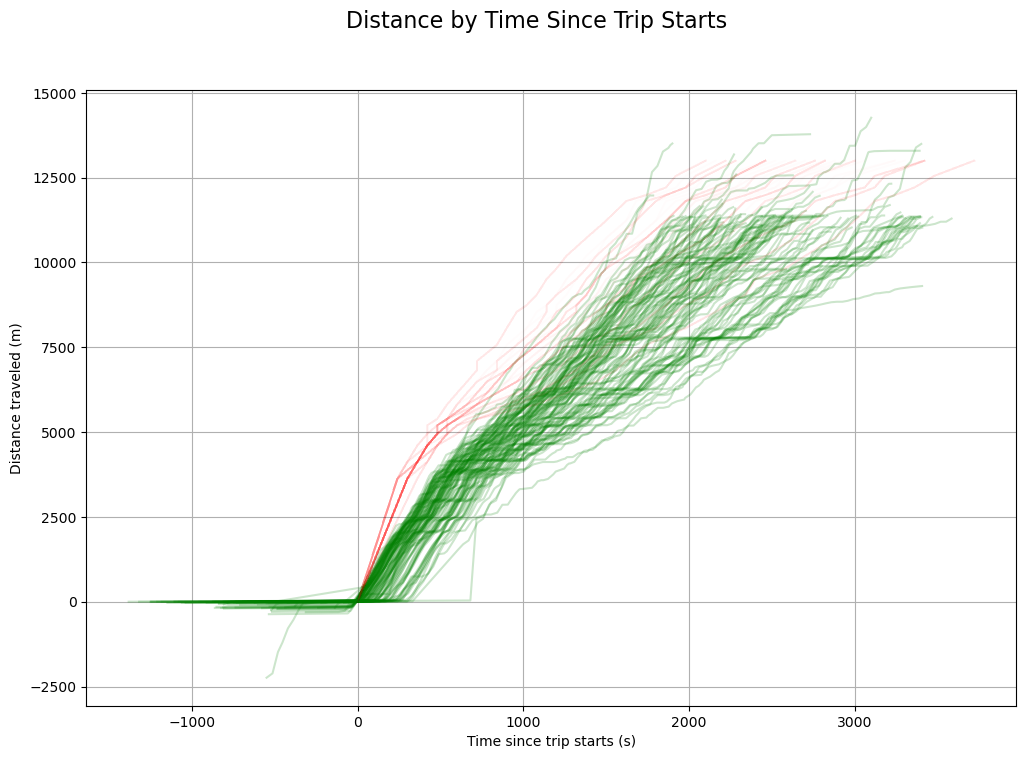

In [349]:
plt.figure(figsize=(12, 8))


for i in range(0,len(actual_trip_series_72)):
    plt.plot(actual_trip_series_72[i][0], actual_trip_series_72[i][1], linestyle='-', color='green', label='Actual Trip', alpha=0.2)
    plt.plot(planned_trip_series_72[i][0], planned_trip_series_72[i][1], linestyle='-', color='red', label='Planned Trip', alpha=0.01)


plt.suptitle('Distance by Time Since Trip Starts', fontsize=16)
# plt.title(f"Line {sample_trip.loc[0]['LineRef']} - Direction {direction_check} - Date {sample_trip.loc[0]['DataFrameRef']}")
# plt.title(f"Line {sample_trip.loc[0]['LineRef']} - Direction {direction_check}")
plt.grid(True)
plt.xlabel('Time since trip starts (s)')
plt.ylabel('Distance traveled (m)')

# # plt.plot(actual_time_interp, distance_interp, color='green',  label='Actual Trip')
# # # plt.plot(planned_time_interp, distance_interp, color='red',  label='Planned Trip')
# # plt.plot('TimeCumSumAdj', 'DistanceCumSumAdj', data=sample_trip, linestyle='-', color='green', label='Actual Trip')
# # plt.plot([0]+t_tracking_data['TimeCumSum'].tolist(), [0]+t_tracking_data['DistanceCumSum'].tolist(), linestyle='-', color='red', label='Planned Trip')

# plt.legend(title='Trip Type',
#            loc=2)
# plt.axhline(7700,color='red')
plt.grid(True)
plt.show()

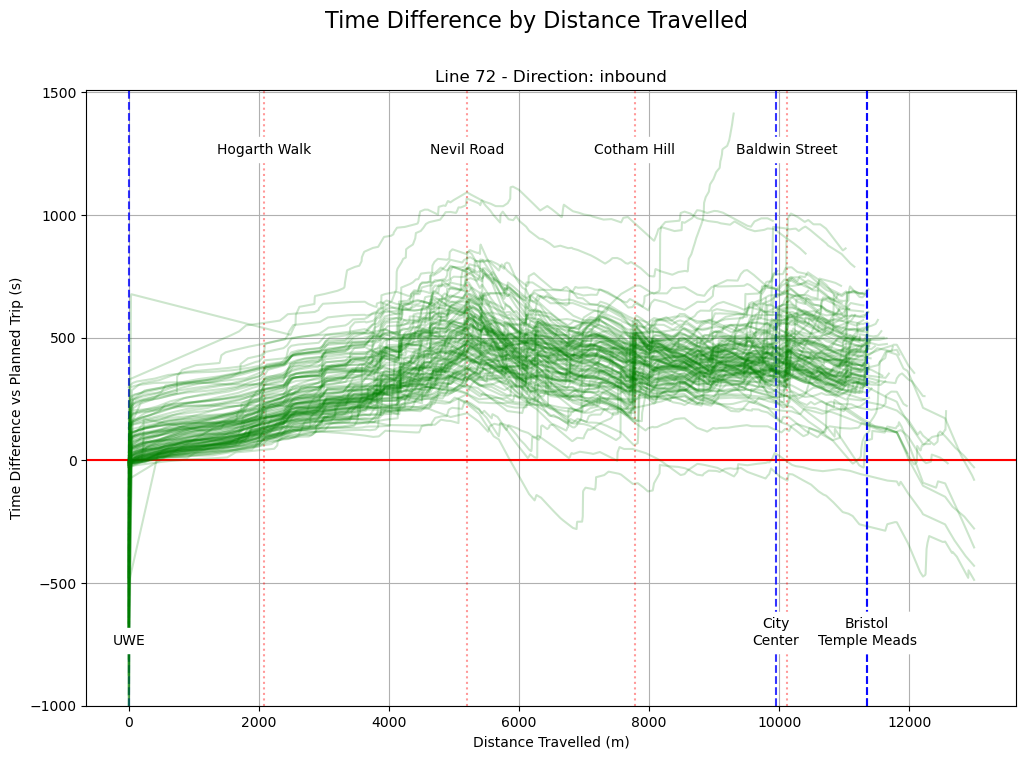

In [424]:
# direction_check = 'inbound'
plt.figure(figsize=(12, 8))

# Annotation

plt.axhline(0,color='red')

plt.annotate(text='Cotham Hill', xy=(7780,1250), ha='center', backgroundcolor="w")
plt.axvline(7780,color='red', linestyle = 'dotted', alpha=0.4)

plt.annotate(text='Baldwin Street', xy=(10120,1250), ha='center', backgroundcolor="w")
plt.axvline(10120,color='red', linestyle = 'dotted', alpha=0.4)

plt.annotate(text='Hogarth Walk', xy=(2080,1250), ha='center', backgroundcolor="w")
plt.axvline(2080,color='red', linestyle = 'dotted', alpha=0.4)

plt.annotate(text='Nevil Road', xy=(5200,1250), ha='center', backgroundcolor="w")
plt.axvline(5200,color='red', linestyle = 'dotted', alpha=0.4)


plt.annotate(text='Bristol\nTemple Meads', xy=(11353,-750), ha='center', backgroundcolor="w")
plt.axvline(11353,color='blue', linestyle = 'dashed', alpha=0.8)


plt.annotate(text='City\nCenter', xy=(9951,-750), ha='center', backgroundcolor="w")
plt.axvline(9951,color='blue', linestyle = 'dashed', alpha=0.8)

plt.annotate(text='Bristol\nTemple Meads', xy=(11353,-750), ha='center', backgroundcolor="w")
plt.axvline(11353,color='blue', linestyle = 'dashed', alpha=0.8)

plt.annotate(text='UWE', xy=(0,-750), ha='center', backgroundcolor="w")
plt.axvline(0,color='blue', linestyle = 'dashed', alpha=0.8)



for i in range(0,len(time_diff_interp_series_72)):
    plt.plot(time_diff_interp_series_72[i][0], time_diff_interp_series_72[i][1], linestyle='-', color='green', alpha=0.2)

# trip_id_check = 'dafbe84b-9d5d-71f9-2ae2-4a753e23655b'
# plot_data = [t for t in time_diff_interp_series if t[2]==trip_id_check][0]
# plt.plot(plot_data[0], plot_data[1], linestyle='-', color='purple', alpha=1)

plt.suptitle('Time Difference by Distance Travelled', fontsize=16)
# plt.title(f"Line {sample_trip.loc[0]['LineRef']} - Direction {direction_check} - Date {sample_trip.loc[0]['DataFrameRef']}")
plt.title(f"Line 72 - Direction: {direction_check}")
plt.grid(True)
plt.xlabel('Distance Travelled (m)')
plt.ylabel('Time Difference vs Planned Trip (s)')

plt.ylim(-1000,1510)
plt.grid(True)
plt.show()

### m3 inbound

#### Analysis

In [422]:
stats = pd.DataFrame()
planned_trip_series_m3=[]
actual_trip_series_m3=[]
time_diff_interp_series_m3=[]
files_line_m3 = [i for i in matched_trip_pkl_files if 'p_m3_' in i]
direction_check = 'inbound'

for f in files_line_m3:
    t_line_data = pd.read_pickle(f)

    t_trips = t_line_data['TripId'].unique().tolist()
    for trip in t_trips:
        # print(f'{trip}/',end='')
        # print(f'{trip}/')
        sample_trip = t_line_data[t_line_data['TripId']==trip].copy().reset_index(drop=True)
        sample_trip = sample_trip[sample_trip['DirectionRef']==direction_check]

        if sample_trip.shape[0] < 80:
            continue
        
        t_estimated_route = eval(sample_trip['EstimatedRoute'][0])
        # sample_trip = sample_trip[sample_trip['RecordedAtTime'] >= sample_trip['OriginAimedDepartureTime']]
        sample_trip['TimeCumSum'] = np.cumsum(sample_trip['TraveledTime'])
        sample_trip['DistanceCumSum'] = np.cumsum(sample_trip['TraveledDistanceMatched'])

        # Calculate Path Properties
        is_wrong_time = False
        is_diverted = False
        is_unplanned = False
        trip_type = 'Other'
        trip_line_name = sample_trip.iloc[0]['LineRef'] 

        t_timetable_data_service = (sample_trip[unique_idetifier_cols+['TripId']]
                            .head(1)
                            .merge(service_lookup_table[service_lookup_id_cols+['RouteRef', 'JourneyPatternSectionRefs']], 'left', 
                                left_on=siri_id_cols, right_on=service_lookup_id_cols))
        t_timetable_data_path = tracking_data.loc[
            (tracking_data['RouteId']==t_timetable_data_service['RouteRef'][0]) &
            (tracking_data['LineRef']==t_timetable_data_service['LineRef'][0])
        ]
        t_timetable_data_time = timing_data.loc[
            (timing_data['JourneyPatternSectionId']==t_timetable_data_service['JourneyPatternSectionRefs'][0]) &
            (timing_data['BlockNumber'].astype(str)==t_timetable_data_service['BlockNumber'].astype(str)[0])
        ]
        t_tracking_data = t_timetable_data_path.merge(t_timetable_data_time, 'left', 
                                                    left_on=['RouteLinkRef'], 
                                                    right_on=['RouteLinkRef']).fillna(0)

        t_tracking_data['TimeCumSum'] = np.cumsum(t_tracking_data['RunTime'])+np.cumsum(t_tracking_data['WaitTime'])
        t_tracking_data['DistanceCumSum'] = np.cumsum(t_tracking_data['Distance'])

        merged_planned_linestring = []
        for segment in t_timetable_data_path['TrackingPoints']:
            merged_planned_linestring = merged_planned_linestring + segment
        merged_planned_linestring = LineString(merged_planned_linestring)
        actual_linestring = gpd.GeoDataFrame(geometry=[t_estimated_route], crs=4326)
        planned_linestring = gpd.GeoDataFrame(geometry=[LineString(segment) for segment in t_timetable_data_path['TrackingPoints']], crs=4326)
        raw_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(sample_trip['Longitude'], sample_trip['Latitude']), crs=4326)

        # Overrall Matching Statistics
        ## Resolution is the number of 5m segments in actual trip
        resolution = int(geod.geometry_length(actual_linestring['geometry'][0])/5)
        actual_linestring_interp = interpolate_line(actual_linestring['geometry'][0], resolution)
        distance_matching = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring_interp.coords]
        match_percentage = (len([i for i in distance_matching if i <=10]))/resolution
        # print(match_percentage)
        # print(np.mean(distance_matching))


        # Calculate Trip Adjustments
        trip_adj = sample_trip[sample_trip['RecordedAtTime'] < sample_trip['OriginAimedDepartureTime']]

        ## If the actual time is shorter than 10 minutes of the ideal timetable (very early arrival), make distance adjustments:
        first_point = sample_trip.iloc[0]
        first_500m_point = sample_trip[sample_trip['DistanceCumSum']>=500].iloc[0]
        last_point = sample_trip.iloc[-1]
        travelled_distance_pre_departure = sum(trip_adj['TraveledDistanceMatched'])
        is_correct_direction = is_points_follow_line(merged_planned_linestring,
                                                    Point([first_point['LongitudeMatched'], first_point['LatitudeMatched']]),
                                                    Point([first_500m_point['LongitudeMatched'], first_500m_point['LatitudeMatched']]))
        # Default value
        strat_trip_adj_time = (sample_trip['RecordedAtTime'][0] - sample_trip['OriginAimedDepartureTime'][0]).total_seconds()
        strat_trip_adj_distance = 0

        if (abs(strat_trip_adj_time) > 30*60) and (travelled_distance_pre_departure > 500):
            # Unplanned/Adhoc
            trip_type = 'Unplanned'
            is_unplanned = True
        elif is_correct_direction and (trip_adj.shape[0] > 0):
            trip_type = 'Starts Recording Early'
            # If the trip starts before expected time
            # start early --> Readjust distance
            strat_trip_adj_distance = -abs(sum(trip_adj['TraveledDistanceMatched']))
        elif is_correct_direction and (trip_adj.shape[0] <= 0):
            trip_type = 'Starts Recording Late'
            # # start late --> Interpolate
            # strat_trip_adj_distance = sum(t_tracking_data["Distance"])*t_estimated_route.project(Point([sample_trip['Longitude'][0],
            #                                                                                             sample_trip['Latitude'][0]]), normalized=True)
            strat_trip_adj_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(Point([sample_trip['Longitude'][0], 
                                                                                                                            sample_trip['Latitude'][0]]), normalized=True)
        elif ~is_correct_direction and match_percentage > 0.8:
            trip_type = 'In Unfinished Previous Trip'
            # Still in previous trip
            actual_start_point = t_estimated_route.project(Point([t_timetable_data_path.iloc[0]['TrackingPoints'][0][0],
                                                                t_timetable_data_path.iloc[0]['TrackingPoints'][0][1]]), normalized=True)
            strat_trip_adj_distance = -1*actual_start_point*geod.geometry_length(t_estimated_route)
        else:
            trip_type = 'Other'
            # Default
            strat_trip_adj_distance = 0


        sample_trip['TimeCumSumAdj'] = sample_trip['TimeCumSum'] + strat_trip_adj_time
        sample_trip['DistanceCumSumAdj'] = sample_trip['DistanceCumSum'] + strat_trip_adj_distance

        # Trip Metrics

        ## Trip Time and Distance
        planned_time = (sum(t_tracking_data["RunTime"])-sum(t_tracking_data["WaitTime"]))
        planned_distance = sum(t_tracking_data["Distance"])
        actual_time = sum(sample_trip["TraveledTime"])+strat_trip_adj_time
        actual_distance = sum(sample_trip["TraveledDistanceMatched"])+strat_trip_adj_distance
        if (actual_time < 0) or (actual_distance < 0):
            is_wrong_time=True
            actual_time = sum(sample_trip["TraveledTime"])
            actual_distance = sum(sample_trip["TraveledDistanceMatched"])

        ## GPS errors
        gps_error_points = []
        prj_points = []
        for index, point in sample_trip.iterrows():
            raw_point = Point([point['Longitude'],point['Latitude']])
            raw_point_projection = merged_planned_linestring.project(raw_point)
            proj_raw_point_to_planned_trip = merged_planned_linestring.interpolate(raw_point_projection, normalized=False)
            distance_to_planned_route = geopy.distance.geodesic(raw_point.coords, proj_raw_point_to_planned_trip.coords).meters
            gps_error_points.append(distance_to_planned_route)
            prj_points.append(proj_raw_point_to_planned_trip)
            # print(f'\t\t{raw_point}:{proj_raw_point_to_planned_trip}-{distance_to_planned_route}')
            # print(row['c1'], row['c2'])
        # print(f'Median GPS error: {np.median(gps_error_points)}')

        ## Diversion Check
        distance_matching_diversion_check = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring['geometry'][0].coords]
        # diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 100]
        diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 50]
        diversion_data = []
        diversion_count = 0
        # diversion_check_df = pd.DataFrame()
        if len(diversion_check) > 0:
            actual_segment_count = len(actual_linestring['geometry'][0].coords)
            diversion_group = clutter_grouping(diversion_check,2,int(actual_segment_count*0.01),record_count=len(distance_matching_diversion_check)-1)
            for cluster in diversion_group:
                if cluster[0]!=cluster[1]:
                    # print('DIVERSION DETECTED')
                    diverted_path = LineString([actual_linestring['geometry'][0].coords[i] for i in range(cluster[0], cluster[1]+1)])
                    diverted_path_length = geod.geometry_length(diverted_path)
                    diversion_start_point = actual_linestring['geometry'][0].coords[cluster[0]]
                    diversion_end_point = actual_linestring['geometry'][0].coords[cluster[1]]
                    diversion_cluster = {
                        'diverted_path': linestring_to_string(diverted_path),
                        'diverted_path_length': diverted_path_length,
                        'diversion_start_point': diversion_start_point,
                        'diversion_end_point': diversion_end_point
                    }
                    # diversion_check_df = df_insert_row(diversion_check_df, diversion_cluster)
                    if diverted_path_length>400:
                        diversion_count+=1
                        diversion_data.append(diversion_cluster)
        
        diversion_data = np.nan if diversion_data == [] else diversion_data

        ## Punctuation
        ### Interpolate actual data
        # actual_distance_interp = np.arange(int(list(sample_trip['DistanceCumSumAdj'])[0]), int(list(sample_trip['DistanceCumSumAdj'])[-1]), 5)
        distance_interp = np.arange(max(0, int(list(sample_trip['DistanceCumSumAdj'])[0])), 
                                    min(int(list(sample_trip['DistanceCumSumAdj'])[-1]), int(list(t_tracking_data['DistanceCumSum'])[-1])), 5)
        if len(distance_interp) > 1:
            actual_time_interp = np.interp(distance_interp, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist())
            planned_time_interp = np.interp(distance_interp, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            ## Get difference series
            ### Negative is earlier than planned and vice versa
            #### Overall Performance
            time_difference = actual_time_interp - planned_time_interp
            total_deviation = float(sum(time_difference))
            mean_deviation = float(np.mean(time_difference))
            std_deviation = float(np.std(time_difference))
            median_deviation = float(np.median(time_difference))
            max_deviation = float(max(time_difference))
            min_deviation = float(min(time_difference))
            deviation_per_km = float(sum(time_difference))/planned_distance
            #### Punctuation Performance
            percentage_ontime = sum((t <= 5*60) and (t >= -1*60) for t in time_difference)/len(time_difference)
            percentage_late = sum((t > 5*60)for t in time_difference)/len(time_difference)
            percentage_early = sum((t < -1*60) for t in time_difference)/len(time_difference)
            segment_sample_size = len(time_difference)
        else:
            time_difference = np.nan
            total_deviation = np.nan
            mean_deviation = np.nan
            std_deviation = np.nan
            median_deviation = np.nan
            max_deviation = np.nan
            min_deviation = np.nan
            deviation_per_km = np.nan
            #### Punctuation Performance
            percentage_ontime = np.nan
            percentage_late = np.nan
            percentage_early = np.nan
            segment_sample_size = len(distance_interp)

        
        btm_distance = np.nan
        bp_distance = np.nan
        bcc_distance = np.nan
        btm_time_diff = np.nan
        bp_time_diff = np.nan
        bcc_time_diff = np.nan

        if len(distance_interp) > 1:
            if trip_line_name in ['74','72']:
                btm_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_temple_meads, normalized=True)
                btm_distance_mapping = min(btm_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                btm_time_diff = np.interp(btm_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(btm_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            if trip_line_name in ['m4']:
                bp_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_parkway, normalized=True)
                bp_distance_mapping = min(bp_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                bp_time_diff = np.interp(bp_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bp_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            if trip_line_name in ['70','72','74','m1','m3','m4']:
                bcc_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_broadquay, normalized=True)
                bcc_distance_mapping = min(bcc_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                bcc_time_diff = np.interp(bcc_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bcc_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())

        raw_projected_points = gpd.GeoDataFrame(geometry=prj_points, crs=4326)

        if strat_trip_adj_time < -2000:
            print(f'\n\t\t{f} - {trip}')
        
        if str(trip_type) in ['Unplanned', 'Other']:
            print('NAHHHHH')
            # # time, distance series
        else:
            actual_trip_series_m3.append((sample_trip['TimeCumSumAdj'].tolist(), sample_trip['DistanceCumSumAdj'].tolist()))
            planned_trip_series_m3.append(([0]+t_tracking_data['TimeCumSum'].tolist(), [0]+t_tracking_data['DistanceCumSum'].tolist()))
        
        if len(distance_interp) > 1:
            time_diff_interp_series_m3.append((distance_interp, time_difference, trip))

NAHHHHH

		./data/processed/trips_matched/p_m3_20240725.pkl - 4c852ab2-7fdc-9dbe-9a10-1f90394002fc
NAHHHHH
NAHHHHH
NAHHHHH


#### Visualisation

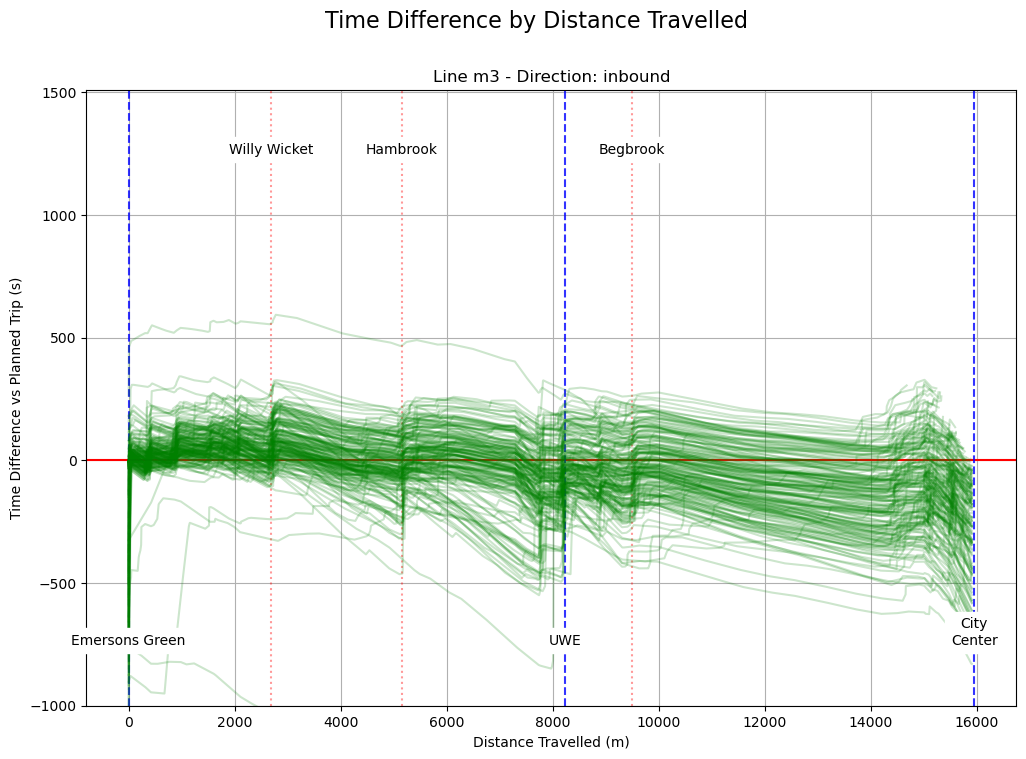

In [423]:
plt.figure(figsize=(12, 8))

# Annotation

plt.axhline(0,color='red')

plt.annotate(text='Willy Wicket', xy=(2680,1250), ha='center', backgroundcolor="w")
plt.axvline(2680,color='red', linestyle = 'dotted', alpha=0.4)

plt.annotate(text='Hambrook', xy=(5150,1250), ha='center', backgroundcolor="w")
plt.axvline(5150,color='red', linestyle = 'dotted', alpha=0.4)

# plt.annotate(text='Hogarth Walk', xy=(2080,1250), ha='center', backgroundcolor="w")
# plt.axvline(2080,color='red', linestyle = 'dotted', alpha=0.4)

plt.annotate(text='Begbrook', xy=(9500,1250), ha='center', backgroundcolor="w")
plt.axvline(9500,color='red', linestyle = 'dotted', alpha=0.4)


plt.annotate(text='Emersons Green', xy=(0,-750), ha='center', backgroundcolor="w")
plt.axvline(0,color='blue', linestyle = 'dashed', alpha=0.8)

plt.annotate(text='City\nCenter', xy=(15948,-750), ha='center', backgroundcolor="w")
plt.axvline(15948,color='blue', linestyle = 'dashed', alpha=0.8)

# plt.annotate(text='Bristol\nTemple Meads', xy=(11353,-750), ha='center', backgroundcolor="w")
# plt.axvline(2680,color='blue', linestyle = 'dashed', alpha=0.8)

plt.annotate(text='UWE', xy=(8232,-750), ha='center', backgroundcolor="w")
plt.axvline(8232,color='blue', linestyle = 'dashed', alpha=0.8)

for i in range(0,len(time_diff_interp_series_m3)):
    plt.plot(time_diff_interp_series_m3[i][0], time_diff_interp_series_m3[i][1], linestyle='-', color='green', alpha=0.2)

# trip_id_check = 'dafbe84b-9d5d-71f9-2ae2-4a753e23655b'
# plot_data = [t for t in time_diff_interp_series if t[2]==trip_id_check][0]
# plt.plot(plot_data[0], plot_data[1], linestyle='-', color='purple', alpha=1)

plt.suptitle('Time Difference by Distance Travelled', fontsize=16)
# plt.title(f"Line {sample_trip.loc[0]['LineRef']} - Direction {direction_check} - Date {sample_trip.loc[0]['DataFrameRef']}")
plt.title(f"Line m3 - Direction: {direction_check}")
plt.grid(True)
plt.xlabel('Distance Travelled (m)')
plt.ylabel('Time Difference vs Planned Trip (s)')

plt.ylim(-1000,1510)
plt.grid(True)
plt.show()

### m4 outbound

#### Analysis

In [419]:
stats = pd.DataFrame()
planned_trip_series_m4=[]
actual_trip_series_m4=[]
time_diff_interp_series_m4=[]
files_line_m4 = [i for i in matched_trip_pkl_files if 'p_m4_' in i]
direction_check = 'outbound'

for f in files_line_m3:
    t_line_data = pd.read_pickle(f)

    t_trips = t_line_data['TripId'].unique().tolist()
    for trip in t_trips:
        # print(f'{trip}/',end='')
        # print(f'{trip}/')
        sample_trip = t_line_data[t_line_data['TripId']==trip].copy().reset_index(drop=True)
        sample_trip = sample_trip[sample_trip['DirectionRef']==direction_check]

        if sample_trip.shape[0] < 80:
            continue
        
        t_estimated_route = eval(sample_trip['EstimatedRoute'][0])
        # sample_trip = sample_trip[sample_trip['RecordedAtTime'] >= sample_trip['OriginAimedDepartureTime']]
        sample_trip['TimeCumSum'] = np.cumsum(sample_trip['TraveledTime'])
        sample_trip['DistanceCumSum'] = np.cumsum(sample_trip['TraveledDistanceMatched'])

        # Calculate Path Properties
        is_wrong_time = False
        is_diverted = False
        is_unplanned = False
        trip_type = 'Other'
        trip_line_name = sample_trip.iloc[0]['LineRef'] 

        t_timetable_data_service = (sample_trip[unique_idetifier_cols+['TripId']]
                            .head(1)
                            .merge(service_lookup_table[service_lookup_id_cols+['RouteRef', 'JourneyPatternSectionRefs']], 'left', 
                                left_on=siri_id_cols, right_on=service_lookup_id_cols))
        t_timetable_data_path = tracking_data.loc[
            (tracking_data['RouteId']==t_timetable_data_service['RouteRef'][0]) &
            (tracking_data['LineRef']==t_timetable_data_service['LineRef'][0])
        ]
        t_timetable_data_time = timing_data.loc[
            (timing_data['JourneyPatternSectionId']==t_timetable_data_service['JourneyPatternSectionRefs'][0]) &
            (timing_data['BlockNumber'].astype(str)==t_timetable_data_service['BlockNumber'].astype(str)[0])
        ]
        t_tracking_data = t_timetable_data_path.merge(t_timetable_data_time, 'left', 
                                                    left_on=['RouteLinkRef'], 
                                                    right_on=['RouteLinkRef']).fillna(0)

        t_tracking_data['TimeCumSum'] = np.cumsum(t_tracking_data['RunTime'])+np.cumsum(t_tracking_data['WaitTime'])
        t_tracking_data['DistanceCumSum'] = np.cumsum(t_tracking_data['Distance'])

        merged_planned_linestring = []
        for segment in t_timetable_data_path['TrackingPoints']:
            merged_planned_linestring = merged_planned_linestring + segment
        merged_planned_linestring = LineString(merged_planned_linestring)
        actual_linestring = gpd.GeoDataFrame(geometry=[t_estimated_route], crs=4326)
        planned_linestring = gpd.GeoDataFrame(geometry=[LineString(segment) for segment in t_timetable_data_path['TrackingPoints']], crs=4326)
        raw_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(sample_trip['Longitude'], sample_trip['Latitude']), crs=4326)

        # Overrall Matching Statistics
        ## Resolution is the number of 5m segments in actual trip
        resolution = int(geod.geometry_length(actual_linestring['geometry'][0])/5)
        actual_linestring_interp = interpolate_line(actual_linestring['geometry'][0], resolution)
        distance_matching = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring_interp.coords]
        match_percentage = (len([i for i in distance_matching if i <=10]))/resolution
        # print(match_percentage)
        # print(np.mean(distance_matching))


        # Calculate Trip Adjustments
        trip_adj = sample_trip[sample_trip['RecordedAtTime'] < sample_trip['OriginAimedDepartureTime']]

        ## If the actual time is shorter than 10 minutes of the ideal timetable (very early arrival), make distance adjustments:
        first_point = sample_trip.iloc[0]
        first_500m_point = sample_trip[sample_trip['DistanceCumSum']>=500].iloc[0]
        last_point = sample_trip.iloc[-1]
        travelled_distance_pre_departure = sum(trip_adj['TraveledDistanceMatched'])
        is_correct_direction = is_points_follow_line(merged_planned_linestring,
                                                    Point([first_point['LongitudeMatched'], first_point['LatitudeMatched']]),
                                                    Point([first_500m_point['LongitudeMatched'], first_500m_point['LatitudeMatched']]))
        # Default value
        strat_trip_adj_time = (sample_trip['RecordedAtTime'][0] - sample_trip['OriginAimedDepartureTime'][0]).total_seconds()
        strat_trip_adj_distance = 0

        if (abs(strat_trip_adj_time) > 30*60) and (travelled_distance_pre_departure > 500):
            # Unplanned/Adhoc
            trip_type = 'Unplanned'
            is_unplanned = True
        elif is_correct_direction and (trip_adj.shape[0] > 0):
            trip_type = 'Starts Recording Early'
            # If the trip starts before expected time
            # start early --> Readjust distance
            strat_trip_adj_distance = -abs(sum(trip_adj['TraveledDistanceMatched']))
        elif is_correct_direction and (trip_adj.shape[0] <= 0):
            trip_type = 'Starts Recording Late'
            # # start late --> Interpolate
            # strat_trip_adj_distance = sum(t_tracking_data["Distance"])*t_estimated_route.project(Point([sample_trip['Longitude'][0],
            #                                                                                             sample_trip['Latitude'][0]]), normalized=True)
            strat_trip_adj_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(Point([sample_trip['Longitude'][0], 
                                                                                                                            sample_trip['Latitude'][0]]), normalized=True)
        elif ~is_correct_direction and match_percentage > 0.8:
            trip_type = 'In Unfinished Previous Trip'
            # Still in previous trip
            actual_start_point = t_estimated_route.project(Point([t_timetable_data_path.iloc[0]['TrackingPoints'][0][0],
                                                                t_timetable_data_path.iloc[0]['TrackingPoints'][0][1]]), normalized=True)
            strat_trip_adj_distance = -1*actual_start_point*geod.geometry_length(t_estimated_route)
        else:
            trip_type = 'Other'
            # Default
            strat_trip_adj_distance = 0


        sample_trip['TimeCumSumAdj'] = sample_trip['TimeCumSum'] + strat_trip_adj_time
        sample_trip['DistanceCumSumAdj'] = sample_trip['DistanceCumSum'] + strat_trip_adj_distance

        # Trip Metrics

        ## Trip Time and Distance
        planned_time = (sum(t_tracking_data["RunTime"])-sum(t_tracking_data["WaitTime"]))
        planned_distance = sum(t_tracking_data["Distance"])
        actual_time = sum(sample_trip["TraveledTime"])+strat_trip_adj_time
        actual_distance = sum(sample_trip["TraveledDistanceMatched"])+strat_trip_adj_distance
        if (actual_time < 0) or (actual_distance < 0):
            is_wrong_time=True
            actual_time = sum(sample_trip["TraveledTime"])
            actual_distance = sum(sample_trip["TraveledDistanceMatched"])

        ## GPS errors
        gps_error_points = []
        prj_points = []
        for index, point in sample_trip.iterrows():
            raw_point = Point([point['Longitude'],point['Latitude']])
            raw_point_projection = merged_planned_linestring.project(raw_point)
            proj_raw_point_to_planned_trip = merged_planned_linestring.interpolate(raw_point_projection, normalized=False)
            distance_to_planned_route = geopy.distance.geodesic(raw_point.coords, proj_raw_point_to_planned_trip.coords).meters
            gps_error_points.append(distance_to_planned_route)
            prj_points.append(proj_raw_point_to_planned_trip)
            # print(f'\t\t{raw_point}:{proj_raw_point_to_planned_trip}-{distance_to_planned_route}')
            # print(row['c1'], row['c2'])
        # print(f'Median GPS error: {np.median(gps_error_points)}')

        ## Diversion Check
        distance_matching_diversion_check = [geod.geometry_length(LineString(ops.nearest_points(merged_planned_linestring,Point(p)))) for p in actual_linestring['geometry'][0].coords]
        # diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 100]
        diversion_check = [i for i, value in enumerate(distance_matching_diversion_check) if value > 50]
        diversion_data = []
        diversion_count = 0
        # diversion_check_df = pd.DataFrame()
        if len(diversion_check) > 0:
            actual_segment_count = len(actual_linestring['geometry'][0].coords)
            diversion_group = clutter_grouping(diversion_check,2,int(actual_segment_count*0.01),record_count=len(distance_matching_diversion_check)-1)
            for cluster in diversion_group:
                if cluster[0]!=cluster[1]:
                    # print('DIVERSION DETECTED')
                    diverted_path = LineString([actual_linestring['geometry'][0].coords[i] for i in range(cluster[0], cluster[1]+1)])
                    diverted_path_length = geod.geometry_length(diverted_path)
                    diversion_start_point = actual_linestring['geometry'][0].coords[cluster[0]]
                    diversion_end_point = actual_linestring['geometry'][0].coords[cluster[1]]
                    diversion_cluster = {
                        'diverted_path': linestring_to_string(diverted_path),
                        'diverted_path_length': diverted_path_length,
                        'diversion_start_point': diversion_start_point,
                        'diversion_end_point': diversion_end_point
                    }
                    # diversion_check_df = df_insert_row(diversion_check_df, diversion_cluster)
                    if diverted_path_length>400:
                        diversion_count+=1
                        diversion_data.append(diversion_cluster)
        
        diversion_data = np.nan if diversion_data == [] else diversion_data

        ## Punctuation
        ### Interpolate actual data
        # actual_distance_interp = np.arange(int(list(sample_trip['DistanceCumSumAdj'])[0]), int(list(sample_trip['DistanceCumSumAdj'])[-1]), 5)
        distance_interp = np.arange(max(0, int(list(sample_trip['DistanceCumSumAdj'])[0])), 
                                    min(int(list(sample_trip['DistanceCumSumAdj'])[-1]), int(list(t_tracking_data['DistanceCumSum'])[-1])), 5)
        if len(distance_interp) > 1:
            actual_time_interp = np.interp(distance_interp, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist())
            planned_time_interp = np.interp(distance_interp, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            ## Get difference series
            ### Negative is earlier than planned and vice versa
            #### Overall Performance
            time_difference = actual_time_interp - planned_time_interp
            total_deviation = float(sum(time_difference))
            mean_deviation = float(np.mean(time_difference))
            std_deviation = float(np.std(time_difference))
            median_deviation = float(np.median(time_difference))
            max_deviation = float(max(time_difference))
            min_deviation = float(min(time_difference))
            deviation_per_km = float(sum(time_difference))/planned_distance
            #### Punctuation Performance
            percentage_ontime = sum((t <= 5*60) and (t >= -1*60) for t in time_difference)/len(time_difference)
            percentage_late = sum((t > 5*60)for t in time_difference)/len(time_difference)
            percentage_early = sum((t < -1*60) for t in time_difference)/len(time_difference)
            segment_sample_size = len(time_difference)
        else:
            time_difference = np.nan
            total_deviation = np.nan
            mean_deviation = np.nan
            std_deviation = np.nan
            median_deviation = np.nan
            max_deviation = np.nan
            min_deviation = np.nan
            deviation_per_km = np.nan
            #### Punctuation Performance
            percentage_ontime = np.nan
            percentage_late = np.nan
            percentage_early = np.nan
            segment_sample_size = len(distance_interp)

        
        btm_distance = np.nan
        bp_distance = np.nan
        bcc_distance = np.nan
        btm_time_diff = np.nan
        bp_time_diff = np.nan
        bcc_time_diff = np.nan

        if len(distance_interp) > 1:
            if trip_line_name in ['74','72']:
                btm_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_temple_meads, normalized=True)
                btm_distance_mapping = min(btm_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                btm_time_diff = np.interp(btm_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(btm_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            if trip_line_name in ['m4']:
                bp_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_parkway, normalized=True)
                bp_distance_mapping = min(bp_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                bp_time_diff = np.interp(bp_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bp_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())
            if trip_line_name in ['70','72','74','m1','m3','m4']:
                bcc_distance = geod.geometry_length(merged_planned_linestring)*merged_planned_linestring.project(bristol_broadquay, normalized=True)
                bcc_distance_mapping = min(bcc_distance, max(sample_trip['DistanceCumSumAdj'].tolist()), max(t_tracking_data['DistanceCumSum'].tolist()))
                bcc_time_diff = np.interp(bcc_distance_mapping, sample_trip['DistanceCumSumAdj'].tolist() , sample_trip['TimeCumSumAdj'].tolist()) - np.interp(bcc_distance_mapping, [0]+t_tracking_data['DistanceCumSum'].tolist(), [0]+t_tracking_data['TimeCumSum'].tolist())

        raw_projected_points = gpd.GeoDataFrame(geometry=prj_points, crs=4326)

        if strat_trip_adj_time < -2000:
            print(f'\n\t\t{f} - {trip}')
        
        if str(trip_type) in ['Unplanned', 'Other']:
            print('NAHHHHH')
            # # time, distance series
        else:
            actual_trip_series_m4.append((sample_trip['TimeCumSumAdj'].tolist(), sample_trip['DistanceCumSumAdj'].tolist()))
            planned_trip_series_m4.append(([0]+t_tracking_data['TimeCumSum'].tolist(), [0]+t_tracking_data['DistanceCumSum'].tolist()))
        
        if len(distance_interp) > 1:
            time_diff_interp_series_m4.append((distance_interp, time_difference, trip))

NAHHHHH


#### Visualisation

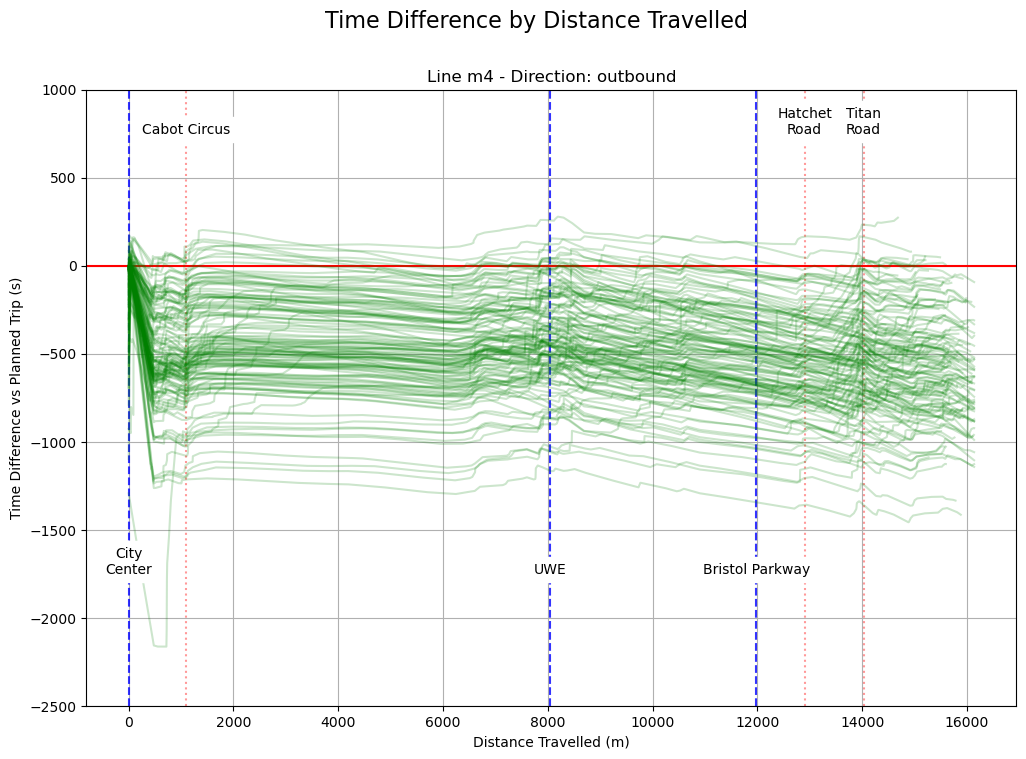

In [420]:
plt.figure(figsize=(12, 8))

# # Annotation

plt.axhline(0,color='red')

plt.annotate(text='Cabot Circus', xy=(1100,750), ha='center', backgroundcolor="w")
plt.axvline(1100,color='red', linestyle = 'dotted', alpha=0.4)

# plt.annotate(text='Hambrook', xy=(5150,1250), ha='center', backgroundcolor="w")
# plt.axvline(5150,color='red', linestyle = 'dotted', alpha=0.4)

plt.annotate(text='Hatchet\nRoad', xy=(12900,750), ha='center', backgroundcolor="w")
plt.axvline(12900,color='red', linestyle = 'dotted', alpha=0.4)

plt.annotate(text='Titan\nRoad', xy=(14025,750), ha='center', backgroundcolor="w")
plt.axvline(14025,color='red', linestyle = 'dotted', alpha=0.4)


# plt.annotate(text='Emersons Green', xy=(0,-750), ha='center', backgroundcolor="w")
# plt.axvline(1000,color='blue', linestyle = 'dashed', alpha=0.8)

plt.annotate(text='City\nCenter', xy=(0,-1750), ha='center', backgroundcolor="w")
plt.axvline(0,color='blue', linestyle = 'dashed', alpha=0.8)

plt.annotate(text='Bristol Parkway', xy=(11980,-1750), ha='center', backgroundcolor="w")
plt.axvline(11980,color='blue', linestyle = 'dashed', alpha=0.8)

plt.annotate(text='UWE', xy=(8049,-1750), ha='center', backgroundcolor="w")
plt.axvline(8049,color='blue', linestyle = 'dashed', alpha=0.8)

for i in range(0,len(time_diff_interp_series_m4)):
    plt.plot(time_diff_interp_series_m4[i][0], time_diff_interp_series_m4[i][1], linestyle='-', color='green', alpha=0.2)

# trip_id_check = 'dafbe84b-9d5d-71f9-2ae2-4a753e23655b'
# plot_data = [t for t in time_diff_interp_series if t[2]==trip_id_check][0]
# plt.plot(plot_data[0], plot_data[1], linestyle='-', color='purple', alpha=1)

plt.suptitle('Time Difference by Distance Travelled', fontsize=16)
# plt.title(f"Line {sample_trip.loc[0]['LineRef']} - Direction {direction_check} - Date {sample_trip.loc[0]['DataFrameRef']}")
plt.title(f"Line m4 - Direction: {direction_check}")
plt.grid(True)
plt.xlabel('Distance Travelled (m)')
plt.ylabel('Time Difference vs Planned Trip (s)')

plt.ylim(-2500,1000)
plt.grid(True)
plt.show()